<a href="https://colab.research.google.com/github/AnFrBo/clap_predictions/blob/main/ADAMS_NLP_SS20_AFBothe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment ADAMS SS 2020

by Anna Franziska Bothe (576309)

##Introduction

The underlying data are retrieved from the blog Medium and contain variables such as the text, author, published date, comments and the total number of claps (equivalent to a like) of many posts. The task is to predict the number of claps on a given data set. Since we have rich textual information like the header, texts and several tags (tag_name, slug, name), we will mainly focus on natural language processing (NLP). Nevertheless, other categorical and numerical features will be implemented. The first part of the assignment consists of setting up the environment and exploring the data, followed by data preparation and text cleaning. Moreover, we will have a look at different methods and constructions of word embedding and compare the performance of "self"-pretrained word embeddings to pretrained word embeddings. Least but not least, the best performing word embedding will be apply to different neural network architecture which will be compared to a baseline models. The model with the lowest MSE will be used for the final prediction.<br>
To give an overview over all chapters and subchapters, Google Colab as well as Jupyter Notebook provide an excellent, responsive table of contents located on the top of the bar on the left.

###Set-up System 

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#load packages/libraries
import pandas as pd
import numpy as np
import seaborn as sns
import time
import os
import pickle

#plots
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams["figure.figsize"] = (18,5)

#text cleaning
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
import re
from bs4 import BeautifulSoup
!pip install unidecode
import unidecode
import spacy #lemmatize and stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

#sentiment analysis
!pip install afinn
from afinn import Afinn

#embeddings/NN
from sklearn.model_selection import train_test_split
import collections
import gensim
from gensim.models import Word2Vec 
from gensim.models import Phrases
from gensim import models
from gensim.models.phrases import Phraser
from gensim.models import KeyedVectors
import unicodedata

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, Dropout, Input
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from tensorflow import keras
from keras.layers import Bidirectional
from keras.models import load_model



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


###Set-up Data
---



In [ ]:
#set working directory
os.chdir("/content/gdrive/My Drive/ADAMS/Assignment") #TO DO: please change to your corresponding wd

In [ ]:
#load data file
data_file = "Train.csv"
train = pd.read_csv(data_file, index_col = False, encoding = "utf-8")

data_file = "Test.csv"
test = pd.read_csv(data_file, index_col = False, encoding = "utf-8")

#train.info() #102.9+ MB

##EDA/Descriptive Statistics

The training data set consists of 279.577 entries and contains 50 different variables representing the meta data retrieved from the scrapped blog posts. All datat was scrapped at November 04, 2018. The testing data set have only 8 different variables and 514 entries. The variable are all in a similar form represented in the training data set.<br>
As the boxplot below shows, the target variable "totalClapCount" has a wide range and extreme outliers. We manually checked some of the extreme outliers to make sure that it is not a scrapping mistake. 50% of the blog posts have 8 claps or less and 75% have 72 claps or less. However, the maximum clap count is 291.706 claps. <br>
In the following subchapter we will concentrate on the descriptives of the train data set. All measurements that are applied to the train set will be applied analogously to the test set before the final prediction (if necessary).

In [ ]:
train.head()

,audioVersionDurationSec,codeBlock,codeBlockCount,collectionId,createdDate,createdDatetime,firstPublishedDate,firstPublishedDatetime,imageCount,isSubscriptionLocked,language,latestPublishedDate,latestPublishedDatetime,linksCount,postId,readingTime,recommends,responsesCreatedCount,socialRecommendsCount,subTitle,tagsCount,text,title,totalClapCount,uniqueSlug,updatedDate,updatedDatetime,url,vote,wordCount,publicationdescription,publicationdomain,publicationfacebookPageName,publicationfollowerCount,publicationname,publicationpublicEmail,publicationslug,publicationtags,publicationtwitterUsername,tag_name,slug,name,postCount,author,bio,userId,userName,usersFollowedByCount,usersFollowedCount,scrappedDate
0,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201,ICOBox is the first and the biggest new genera...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,Blockchain,blockchain,Blockchain,265164.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
1,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201,ICOBox is the first and the biggest new genera...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,Samsung,samsung,Samsung,5708.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
2,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201,ICOBox is the first and the biggest new genera...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,It,it,It,3720.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
3,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,en,2018-01-07,2018-01-07 17:18:38,24,1000c43bcb97,19.716981,0,0,0,Introduction,5,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),0,introduction-3-1000c43bcb97,2018-01-07,2018-01-07 17:18:39,https://medium.com/s/story/introduction-3-1000...,False,4854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Technology,technology,Technology,166125.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104
4,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,en,2018-01-07,2018-01-07 17:18:38,24,1000c43bcb97,19.716981,0,0,0,Introduction,5,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),0,introduction-3-1000c43bcb97,2018-01-07,2018-01-07 17:18:39,https://medium.com/s/story/introduction-3-1000...,False,4854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Robotics,robotics,Robotics,9103.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104


In [ ]:
print(train["totalClapCount"].describe())

count    279577.000000
mean        184.963473
std        1985.353004
min           0.000000
25%           0.000000
50%           8.000000
75%          72.000000
max      291706.000000
Name: totalClapCount, dtype: float64


count    279577.000000
mean        184.932983
std        1985.685059
min           0.000000
25%           0.000000
50%           8.000000
75%          72.000000
max      291706.000000
Name: totalClapCount, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


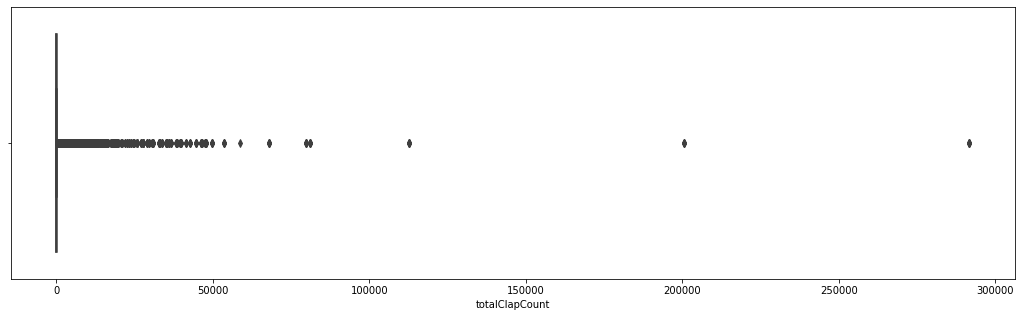

In [ ]:
print(train["totalClapCount"].describe())
print(sns.boxplot(train["totalClapCount"]))

##Data Preparation and Cleaning

###Transformation

All data types will be transformed to more reasonable dtype with less memory consumption and for better and more convenient processing the further analysis.

In [ ]:
#transform all int64 and float64 to float32
num_vars = train.select_dtypes(include=[np.float64, np.int64 ]).columns
train[num_vars] = train[num_vars].astype(np.float32)

#transform all objects to categories
object_vars = train.select_dtypes(exclude=np.float32).columns
train[object_vars] = train[object_vars].astype("category")

train.info() #80.3 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279577 entries, 0 to 279576
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   audioVersionDurationSec      279577 non-null  float32 
 1   codeBlock                    25179 non-null   category
 2   codeBlockCount               279577 non-null  float32 
 3   collectionId                 137878 non-null  category
 4   createdDate                  279577 non-null  category
 5   createdDatetime              279577 non-null  category
 6   firstPublishedDate           279577 non-null  category
 7   firstPublishedDatetime       279577 non-null  category
 8   imageCount                   279577 non-null  float32 
 9   isSubscriptionLocked         279577 non-null  category
 10  language                     279577 non-null  category
 11  latestPublishedDate          279577 non-null  category
 12  latestPublishedDatetime      279577 non-null

###Missing Values

The plot below shows that the data set does not contain many variables with missing data but if they have missing entries than mostly a lot. 10 of 13 of the variable with missing variables have more than 50% NAs. The highest number of missing values -- besides the variable publication follower count with 100% NAs -- is 254398 (approx. 91 %). The corresponding variable is called codeBlock. In contrast, the variable title has the lowest number of missing values with 5 (approx. 0.002 %) missing entries. <br>

Since all missing values miss textual data it is not possible to replace them with numbers such as median, mode or mean. For textual variables the three possibilities are at hand: attempt to scrap the missing data (not allowed for this assignment), replacing them manually or to dummy code them as "available - yes, no (or unknown)". The second approach is only feasible with a low number of missing variables such as title in our case. Also the information has to be available in general. The last approach suits variables such as social media account. They might not be missing entries but rather non-existent.<br>

Spoiler: Out of all variables with missing data only the variable text will be used. The missing value will be imputed by hand.



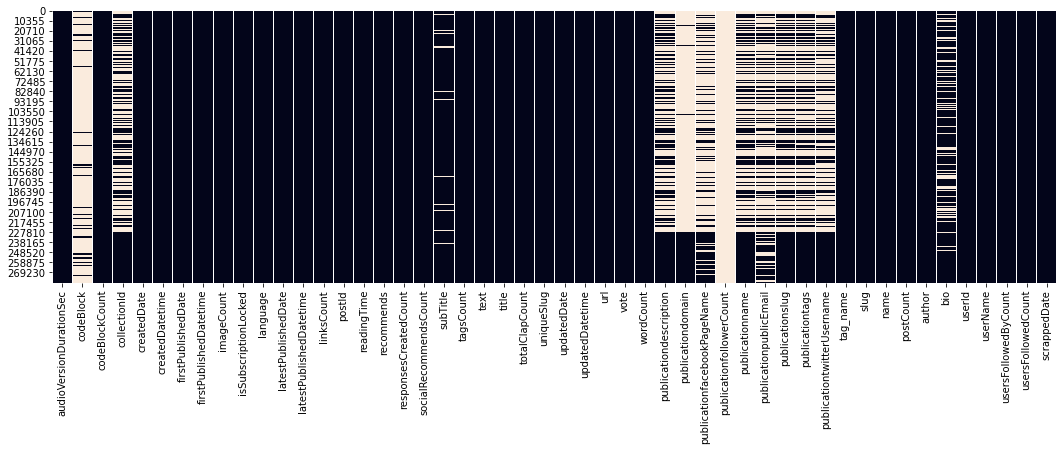

In [ ]:
#visualisation of missing values

sns.heatmap(train.isnull(), cbar = False); #";" gets rid of the message "<matplotlib.axes._subplots.AxesSubplot at 0x7fe969b4bcf8>"

In [ ]:
for z in train:
  if train.loc[:,z].isnull().sum() > 0:
    print('Missing values of {}: {} ({:.3f}%)'.format(z, train.loc[:,z].isnull().sum(), 100*train.loc[:,z].isnull().sum()/train.shape[0]))
    #print(z, train.loc[:,z].isnull().sum())  

Missing values of codeBlock: 254398 (90.994%)
Missing values of collectionId: 141699 (50.683%)
Missing values of subTitle: 8360 (2.990%)
Missing values of title: 5 (0.002%)
Missing values of publicationdescription: 142346 (50.915%)
Missing values of publicationdomain: 225605 (80.695%)
Missing values of publicationfacebookPageName: 178703 (63.919%)
Missing values of publicationfollowerCount: 279577 (100.000%)
Missing values of publicationname: 142346 (50.915%)
Missing values of publicationpublicEmail: 177595 (63.523%)
Missing values of publicationslug: 142346 (50.915%)
Missing values of publicationtags: 149279 (53.395%)
Missing values of publicationtwitterUsername: 159726 (57.131%)
Missing values of bio: 54097 (19.350%)


###Removing Duplicates

As shown in the table below no variable has more than 72.337 unique items. Not even variables like postID, uniqueSlug or url which are unique by nature. This proves that the training data set contains some duplicates that have to be removed. The challenge is that the rows are not fully equal because they contain different keywords (see variables tag_name, slug and name) with corresponding postCounts. Especially the keywords provide valuable information since they sum up the main content of a text. In order to prevent the train set from loosing them, the keywords are merged and the postCounts are summed up. Afterwards, the duplicate rows are removed.

In [ ]:
#unique value per col
train.astype('object').describe(include='all').loc['unique', :]

audioVersionDurationSec           51
codeBlock                       6230
codeBlockCount                   129
collectionId                    6527
createdDate                      741
createdDatetime                72209
firstPublishedDate               610
firstPublishedDatetime         71406
imageCount                        89
isSubscriptionLocked               2
language                          52
latestPublishedDate              577
latestPublishedDatetime        72158
linksCount                       162
postId                         72337
readingTime                    16433
recommends                       887
responsesCreatedCount            139
socialRecommendsCount              4
subTitle                       65673
tagsCount                          6
text                           72024
title                          70275
totalClapCount                  2321
uniqueSlug                     72337
updatedDate                      431
updatedDatetime                71827
u

In [ ]:
#sum up postCounts (pC) per article before removing duplicates of train data set; otherwise, information gets lost
pC = train.groupby(["postId"])["postCount"].apply(sum).reset_index()
#validation check: the difference between train.postCounts and pC.postCount should be 0
print(pC.postCount.sum()-train.postCount.sum())
pC.head()

762.0


,postId,postCount
0,10007d3018fe,274592.0
1,1000b3d0d2,475794.0
2,1000c43bcb97,184243.0
3,100139913e4c,33657.0
4,1002a55eca89,108641.0


In [ ]:
#merging different names "tags" (equal to slug and tag_name) seperated by comma before removing the duplicate entries from data set
tags = train.groupby(["postId"])["name"].apply(', '.join).reset_index()
tags.head()

,postId,name
0,10007d3018fe,"Blockchain, Samsung, It"
1,1000b3d0d2,"Blockchain, Machine Learning, Synapse, Cryptoc..."
2,1000c43bcb97,"Technology, Robotics, Automation, Epq"
3,100139913e4c,"Data Science, Sas Training In Pune, Hadoop Tra..."
4,1002a55eca89,"Robotics, Meditation, Therapy, Artificial Inte..."


In [ ]:
#deleted columns that have already been processed or that are constants

#already used
del train["tag_name"]
del train["slug"]
del train["name"] 
del train["postCount"]

#variable is always null
del train["publicationfollowerCount"] 


In [ ]:
#merge all
train_new = pd.merge(pC, train, on='postId', how='left')
train_new = pd.merge(train_new, tags, on='postId', how='left').drop_duplicates()
train_new.head()

,postId,postCount,audioVersionDurationSec,codeBlock,codeBlockCount,collectionId,createdDate,createdDatetime,firstPublishedDate,firstPublishedDatetime,imageCount,isSubscriptionLocked,language,latestPublishedDate,latestPublishedDatetime,linksCount,readingTime,recommends,responsesCreatedCount,socialRecommendsCount,subTitle,tagsCount,text,title,totalClapCount,uniqueSlug,updatedDate,updatedDatetime,url,vote,wordCount,publicationdescription,publicationdomain,publicationfacebookPageName,publicationname,publicationpublicEmail,publicationslug,publicationtags,publicationtwitterUsername,author,bio,userId,userName,usersFollowedByCount,usersFollowedCount,scrappedDate,name
0,10007d3018fe,274592.0,0.0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1.0,False,en,2018-09-18,2018-09-18 20:58:20,1.0,0.958491,2.0,0.0,0.0,A major private IT company implements blockcha...,5.0,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100.0,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201.0,ICOBox is the first and the biggest new genera...,NaN,icobox.io,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104.0,"Blockchain, Samsung, It"
3,1000b3d0d2,475794.0,0.0,NaN,0.0,ff54a0aaacd7,2017-12-06,2017-12-06 22:23:06,2018-02-24,2018-02-24 19:36:01,2.0,False,en,2018-03-01,2018-03-01 07:44:04,7.0,18.387108,8.0,0.0,0.0,Synapse CEO Dan Gailey is interviewed by Gabe ...,4.0,Democratizing Artificial intelligence by Democ...,Democratizing Artificial intelligence by Democ...,205.0,democratizing-artificial-intelligence-by-democ...,2018-03-27,2018-03-27 20:09:42,https://blog.synapse.ai/democratizing-artifici...,False,4771.0,The Official Synapse Blog,blog.synapse.ai,syntoken,Synapse AI,hello@synapse.ai,synapseai,"ETHEREUM,BLOCKCHAIN,ICO,AI,CRYPTOCURRENCY",aisynapse,Dan Gailey,NaN,112dfc533722,dangailey,913.0,508.0,20181104.0,"Blockchain, Machine Learning, Synapse, Cryptoc..."
7,1000c43bcb97,184243.0,0.0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13.0,False,en,2018-01-07,2018-01-07 17:18:38,24.0,19.716982,0.0,0.0,0.0,Introduction,5.0,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),0.0,introduction-3-1000c43bcb97,2018-01-07,2018-01-07 17:18:39,https://medium.com/s/story/introduction-3-1000...,False,4854.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104.0,"Technology, Robotics, Automation, Epq"
11,100139913e4c,33657.0,0.0,NaN,0.0,NaN,2018-03-08,2018-03-08 07:04:31,2018-03-08,2018-03-08 07:07:42,1.0,False,en,2018-03-08,2018-03-08 07:07:42,3.0,2.211321,0.0,0.0,0.0,Various associations in the present days are o...,4.0,"Ascent of data Science, SAS and Big data Analy...","Ascent of data Science, SAS and Big data Analy...",0.0,ascent-of-data-science-sas-and-big-data-analys...,2018-03-08,2018-03-08 07:07:42,https://medium.com/s/story/ascent-of-data-scie...,False,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tech data,Tech data Providing Courses Like SaS Training ...,60a3bfd83742,techdatasolutions18,4.0,1.0,20181104.0,"Data Science, Sas Training In Pune, Hadoop Tra..."
15,1002a55eca89,108641.0,0.0,NaN,0.0,a8fc5dd0676e,2018-04-16,2018-04-16 22:49:09,2018-04-16,2018-04-16 22:58:07,0.0,False,en,2018-04-16,2018-04-16 22:58:07,2.0,0.652830,1.0,0.0,0.0,I discussed this with Michelle Tsng on my Podc...,5.0,Can a robot love us better than another human ...,Can a robot love us better than another human ...,50.0,can-a-robot-love-us-better-than-another-human-...,2018-04-20,2018-04-20 00:47:51,https://medium.com/s/story/can-a-robot-love-us...,False,173.0,Non-obvious meditation advice from people on t...,NaN,yogastew,Crazy Wisdom,salsop@yogastew.org,crazy-wisdom,"MEDITATION,MINDFULNESS,YOGA,CREATIVITY,BUSINESS",stewartalsopIII,Stewart A

In [ ]:
#validation check: in the end new data set should have the length of the tags or respectively pC 
print(len(pC))
print(len(tags))
print(len(train_new))

72337
72337
72337


###Language Cleaning

The list below shows that 66380 of 72337 blog posts are written in English which is almost 92%. The second most used language is Spanish with only around 1% of the texts being in this language. It is a trade-off between introducing noise with rare data that is difficult to handle but also with holding back information not at random which might also introduce bias. Moreover, the applied models have no possibility to pick up patterns that are connected with non English posts. <br> We decided that the introduced noise due to different languages weights much heavier and therefore we excluded all languages except English from the further analysis. On top, it is possible to check the plausibility of results of the text after text cleaning. <br>


In [ ]:
#language handling
print(len(train_new))
train_new['language'].value_counts()

72337


en         66380
es           890
zh-Hant      880
pt           873
fr           551
tr           378
th           350
ru           347
ja           334
it           218
id           200
ko           200
zh           105
de           102
un            93
vi            88
nl            71
sv            57
pl            25
cs            22
bn            20
no            15
is            15
da            13
my            12
ar            10
uk            10
mn             9
el             8
lo             7
hi             6
la             5
si             5
bg             4
sk             4
sr             3
fa             3
ka             3
ro             3
ca             2
lv             2
nn             2
ms             2
hu             2
te             1
az             1
mk             1
sl             1
lt             1
mr             1
ml             1
fi             1
Name: language, dtype: int64

In [ ]:
train_new = train_new[train_new.language == "en"]
train_new.shape

(66380, 47)

66.380 (started with: 279.577) data points will be processed in the text cleaning. About 30% of all claps are 0.

###Correlation

The upcoming chapter function as a pre-selection of non-textual variables. <br>
The variable "responsesCreatedCount" in the training set is the same as the variable "responses" in the testing data set. The variable has no missing values and at least 75% of the variable is 0. Nevertheless, the variable has a medium correlation of about 0.58 with the target variable and
will be used for training. The variable does not need any processing in the train set. However, in the test set the words "responses" and "response" have been removed. <br>
Another interesting finding was the very high eta coefficient between the variable author and the target variable. An eta coefficient of 0.76 indicates a medium to strong association (depending on the source, see e.g. [2]). Thus, the variable will be integrate in the prediction task. Since it is a nominal-scaled variable, target encoding will be applied (and discussed) after train-test-splitting. This transformation is need to be able to process the data via neural networds. <br>
Surprisingly, variables such as length of texts/word count and postCount have no strong association with the target variable. The correlations were between -0.1 and 0.1.

In [ ]:
print(train_new.responsesCreatedCount.describe())
print(train_new.responsesCreatedCount.isnull().sum())
print(np.corrcoef(train_new.responsesCreatedCount, train_new.totalClapCount))

count    66380.000000
mean         0.902757
std         14.940658
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3076.000000
Name: responsesCreatedCount, dtype: float64
0
[[1.         0.57761543]
 [0.57761543 1.        ]]


In [ ]:
#correlation between authors and claps (eta-coefficient)
#code source: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

train_new = train_new.reset_index(drop = True)

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
        y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
        numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
        denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
        
        if numerator == 0:
          eta = 0.0
        else:
          eta = np.sqrt(numerator/denominator)

    return eta

correlation_ratio(train_new["author"], train_new["totalClapCount"])

0.7575183107222517

In [ ]:
#most frequent authors
print(train_new.author.value_counts().head(10))
train_new.author.isnull().sum()

Synced                  377
DEEP AERO DRONES        279
Yves Mulkers            279
AI Hawk                 245
Jae Duk Seo             173
C Gavilanes             164
WELTARE Strategies      141
TWiML & AI              136
Michael K. Spencer      124
Corsair's Publishing    121
Name: author, dtype: int64


0

In [ ]:
print(np.corrcoef(tr_cl.recommends, tr_cl.totalClapCount)) 
#very strong relationship: 0.96; no corresponding variable in test set

[[1.         0.96155606]
 [0.96155606 1.        ]]


###Text Cleaning

---



The last step of the data preparation is the text cleaning. As stated above, the variables text, header and the newly created variable tags will be used for the NLP analysis. <br> 

Before applying the text cleaning, we put the focus on a few lacks in content (= texts with \n, NaN/Na or almost no content). Some texts are very short or contain no content (such as \n, NaN etc.); however, they have claps. I randomly checked about 50 webpages that all complied with the following reason: The reason is that the original articles contain images (mostly with texts or code) that could not be scraped. The reconstruction is not possible (in case of the non-existing webpage, e.g. error code 110 (the author deleted his Medium story)) or exceeds/fails the scope of the course (extracting text from images). Thus, the representation of the text length relatively to their number of claps is not representative here and might introduce noisy and wrong indications. Anyways, the correlation of the text length and the number of claps is with 0.09 very weak (compare [3]). All texts were kept. The "tags" (var: name) contain the most important keywords regarding the texts; thus, they are merge with the texts. The tags are placed at the beginning of the sentence to make sure they are not lost during the cleaning process (last step: truncating the number of tokens). Also the headers are added to the text. <br> If reconstruction was possible, we imputed some missing values manually. As an example: one text got somehow stuck with the code block during the scraping process; another text with many likes existed and we just copied it to the data frame.


In [ ]:
train_new["text"] = train_new["text"].astype("object")

#correlation text length and number of claps
train_new["len_text"] = [len(x) for x in train_new.text.values]
print(np.corrcoef(train_new.len_text, train_new.totalClapCount))
#merge name with text (includes title already) to one column; the variable name is in the beginning because it contains the most important key words of the text
train_new["text"] = train_new.name + " " + train_new.text
train_new["len_text"] = [len(x) for x in train_new.text.values]

train_new.loc[(train_new.len_text < 100) & (train_new.totalClapCount > 0 ), ["postId", "totalClapCount", "text"]]

[[1.         0.09353421]
 [0.09353421 1.        ]]


,postId,totalClapCount,text
1209,146c91e8eff3,1.0,Data Science Ilona’s Test\nThis is simply a te...
6980,29b7ab1c99b0,1.0,"Philosophy, Future McKenna on Super AI\n\n"
7598,2bf3c93d8f85,66.0,"Machine Learning, Westworld Some thoughts on v..."
9878,345a3015e1a0,1.0,"Social Media, Artificial Intelligence, Wellnes..."
11224,3916fd0334d8,632.0,"Bottos, Blockchain, Artificial Intelligence, C..."
12685,3e691fa8543b,321.0,"Burning Man, Machine Learning, Blockchain, Blo..."
13565,41b7d4739d80,10.0,"Automotive, Innovation, Robotics Autonomous Ve..."
15565,48a0523224e5,1.0,"Data Science, Learning, Tableau Homework #4-Ji..."
16069,4a852c39df75,60.0,"Chatbots, Bots, Artificial Intelligence, Machi..."
19089,559f7443f052,2.0,"Blockchain, Deepbrain DeepBrain Chain Weekly R..."


In [ ]:
#in this case the code block contains the original text; the variable text is empty, thus, the empty text will be replace by the text of the codeBlock
train_new.text[train_new.postId == "6bbd49b10dd6"] = train_new.codeBlock[train_new.postId == "6bbd49b10dd6"]

In [ ]:
#this text was not scraped properly, however it contains many claps and the text exists; thus, I decided to copy and implement the text manually
print(train_new.url[53531])
text_3e691fa8543b = "one of my earliest memories where I am alone, I am writing in a little notebook. at the time I carried around with me inventor notebooks that contained different types of inventions. I had one for safety inventions, one for toys I invented, and my favorite one, the one with the most designs and specs was my flying car notebook. It was filled with every way I could think of that could make a “car” fly. At the time I was ~7 and only drove one of these: When I got older I started to throw out ideas to solve social problems, they ranged from //saving dogs from kill shelters and giving them to families with mental health problems like my own// to //creating spaces for community members to come together and cook//. Unfortunately at the time I was relatively shy and had a hard time telling anyone my ideas beyond my Mother and Father. Me, Kirsten (my american girl doll), my mother Sharon Reddick, my father Edward Chilmonik ll, and Cissy my first Dog just deeep in the 90's My house sat just across the river from the Colville Reservation in Omak, Washington. I had lived on the reservation side for a while when I was younger but as non-tribal members my parents couldn't by property on tribal lands. Omak is 2 hours from a mall and 4 hours from a commercial airport. The biggest event of the year there is the Suicide Race, the steepest horse race in the world. During my senior year my science teacher, Nancy Ridenour, asked my class to do a report on a STEM job. I chose civil/environmental engineering nearly at random out of a list. After presenting the report, I thought, “I guess this is my destiny.” I had done ballet for 16 years, competed in California and had won 1st place in a National Point Solo competition last year, but had broken my foot this year and realized how uncertain a career in the arts could be for me. Mrs. Ridenour was an inspiration to me as a young woman who had talents in math and science and so it felt simply <right> I was extremely supported in Omak. I was a cheerleader, a dancer, a church goer, close to my family, had lots of friends, was prom princess, and valedictorian. My first step out of that fishbowl was college. ~engineering school~is harrrddd. I wasn’t a studier. I had trouble concentrating in long classes. I realized that school was competitive and people weren’t always nice. I tore my ACL after my first month of school and felt utterly alone. My biggest bright spot was my roommate Pooja. We had met at orientation and our mothers liked each other immediately & they set us up as roommates. She was a brilliant young woman with high ambitions and endless empathy. She was studying Biomedical Engineering with a Father in Computer Science and through her I learned a lot more about the other options in engineering. Because I couldn’t dance at my previous level anymore I started to paint as well. This combination pushed me toward the intersection of software and art. Taking a class in transportation engineering was my final straw. I thought this might draw me closer to my *flying~car~dreams* but I ended up on a street corner counting cars for homework. I was done. I decided to switch my major to Systems Engineering. It had much more to do with math and programming. After school and a job as a developer in DC at a startup called Routeam I moved to NYC to accept a job at Thicket Labs. Since then I have learned and done a lot of things. During a period of depression being separated again from friends and family I asked myself what will make me get up each morning? What can I promise myself that will motivate me? What do I think is worth living for? Machine Learning was my answer the podcast Linear Digressions probably kept me alive. I spent most of my free time learning about ML algorithms and trying them out on my computer. I avoided any classes because they would take all the fun out of it for me. My boss Deepthi Welaratna suggested I apply for NASA datanauts. This was one of the best decisions for my career and social life. I was invited to present at NASA Headquarters in DC, that year I spoke at SXSW on behalf of Thicket Labs about self organizing maps (a kind of neural net), spoke to young data scientists at the American Museum of Natural History in NYC and taught a class at CoLab-Factory on Machine Learning for Business Application. Coming up on this last winter of 2017 I took time off work to explore how I could really support this new habit through my work in the most impactful way. ~Enter Byzantine~ Sam Hutch had been my roommate when I first moved to NYC and we worked together at Thicket Labs for a while before she left. There she has always astonished me with the quality and quantity of her work. She was amazing at design, UX, UI, and understanding complexity but most of all was a person I believed to be good at heart & quite cunning. She had reached out to me about a new company she was forming with another one of our former coworkers and introduced me to the new-new world of blockchain! back in college I had dabbled in crypto investing a small amount into Bitcoin (HODL) and had read early white papers at that time, but hadn’t been an avid follower of the industry for the last two years. They contacted me about their vision and hinted that they were interested in working with me. Immediately I learned everything about the industry I could. I fell in love once again with a tech revolution that gave me life. I have deep respect for Sam and luckily for me they saw that spark of an inventor, tinkerer, polymath and experimentalist in me and asked me to become Chief Discovery Officer. I SAID YES! At Byzantine we aren’t just stopping with tech innovation, we are blurring the lines between the physical and digital worlds. Byzantine has a space in Brooklyn over 92,000 sq. ft and our footprint will be expanding fast. We are managing a community called Liminal (our cute name that means “the place in between” in this case — digital and physical worlds) in our spaces that provides digital creators, technologists, and artists a place to co-create with access to resources like — Motion capture suits from Rokoko, Sound production booths, Live streaming studios, Maker Equipment, Mixed Reality Cubes, High speed computing, even higher speed internet (necessary for blockchain & game development), gallery space and much more. You may say ~WHOA there, that sounds EXpExnSive! Well it is! But thats why Byzantine has a two pronged approach — providing resources and building resources. We are in development of a Mobile IOS game with live player interactions built on the blockchain. The idea for the game came from Sam who brilliantly came up with a deeply engaging strategy game thats a mix between Farmville/Animal Crossing and Burning Man culture called *PLAYA*. The in game currencies are NFTs or unique encrypted tokens built on the blockchain. If you don’t know how transformative that is, I don’t blame you. This industry is moving fast. but it basically turns the gaming industry on its head because now game players can actually extract monetary IRL/Fiat/USD (etc.) value out of their in-game assets. Playa will push the boundaries between digital and physical environments even more by interacting through beacons with the physical spaces Byzantine and partners own, and unlocking events, rooms, and more though in-game achievements. Our first step toward releasing this game is #Space Quest# it is the first round of tokens for sale for use in the game! This is a product sale for in-game and IRL perks but happily can also be traded/sold on the market once they are all bought. After the last Space Quest Tile is sold there will be a “Flip Event” where the tiles will expose their metadata and the unique art that has meaning in Playa lore will be revealed. “Imagine if every dollar was a unique piece of art” The tiles are valued in Ethereum (ETH) which at the time of publishing was worth $ USD and climbing. The tiles are sold at increasing rates according to a step function (SALE is over since time of publishing) I hope that the Liminal spaces and similar innovative spaces we are building today will be the “Open Source Bell Labs” that will finally make my 10 types of flying cars a reality. My inner child is most excited about supporting all types of artists, technologists, philosophers, and makers to move past incremental innovations into a new age of radical innovation through cross-pollination of industries and radical inclusion."
train_new.text[train_new.postId == "3e691fa8543b"] = text_3e691fa8543b

As already stated, the variable title has only 5 missing values. Since the title represents a crucial information and is needed before text cleaning, the missing values will be looked up and imputed manually.

In [ ]:
#add the missing titles manually; where all the same
train_new.title[train_new.title.isnull()] = "How I Became Chief Discovery Officer of a Blockchain Company by age 25"

In order to make the text cleaning more efficient, we cut the max. sentence length at 2000. Since we will cut the max. length after processing to 400 anyways, setting it to 2000 reduces the computational time but ensures that no information that is needed it lost. <br>
Of course, we applied a stop word removal; however, we decided that words such as no, not and nothing might have a contextual impact. Moreover, we used contraction mapping to keep certain sequences such as "does not" which would otherwised be removed during the cleaning process. <br>
Lemmatization transforms a word into its lexicographically correct word and thus is used to reduce the amount of words but minimizes minor difference such as a word in singluar and plural which can be analysed as being the same word. The package nltk as well as spaCy both have excellent functions for the lemmatization of words. <br>
Furthermore, the following cleaning steps have been applied:

* removal of hmtl tags
* removal of non alphanumeric letters (numbers, punctuation, hypens)
* lowering text
* removal white spaces if there are more than one between words
* replace "data" to "datum" (falsely change during lemmatization and costs are higher for loosing the word data then for falsely misreplacing datum)
* removal of single letters 


In [ ]:
#general setting for preparation of the cleaning process such as:

max_len_sentence = 2000

  #loading stop words and excluding no, not and nothing since they might have a strong contextual impact and the meaning of a
  #sequence in order to be able to detect all see next step: contractionmapping

nlp = spacy.load("en", disable=['parser', 'ner']) #keeping only tagger component needed for lemmatization and contains of list of english stop words (see nlp.Defaults.stop_words)

#keep
keep = {"no", "not", "nothing"} 

#remove
remove = {"www", "http", "https", "com", "html"} #these tokens should be removed
stop_words = set([re.sub(r"\W", "", word) for word in nlp.Defaults.stop_words if word not in keep])
  
  #constraction mapper --> especially used to be able to keep the "not" which contain an important contextual message and should
  #not be lost during the cleaning process; they will also be excluded from removing the stopwords -- as well as the words "no" and "nothing".
  #source: https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py
  
contraction_mapping = { 
    "ain't": "is not", 
    "aren't": "are not", 
    "can't": "cannot", 
    "'cause": "because", 
    "could've": "could have", 
    "couldn't": "could not",
    "didn't": "did not", 
    "doesn't": "does not", 
    "don't": "do not", 
    "hadn't": "had not", 
    "hasn't": "has not", 
    "haven't": "have not",
    "he'd": "he would", 
    "he'll": "he will", 
    "he's": "he is", 
    "how'd": "how did", 
    "how'd'y": "how do you", 
    "how'll": "how will", 
    "how's": "how is",
    "I'd": "I would", 
    "I'd've": "I would have", 
    "I'll": "I will", 
    "I'll've": "I will have", 
    "I'm": "I am", 
    "I've": "I have", 
    "i'd": "i would",
    "i'd've": "i would have", 
    "i'll": "i will", 
    "i'll've": "i will have", 
    "i'm": "i am", 
    "i've": "i have", 
    "isn't": "is not", 
    "it'd": "it would",
    "it'd've": "it would have", 
    "it'll": "it will", 
    "it'll've": "it will have", 
    "it's": "it is", 
    "let's": "let us", 
    "ma'am": "madam",
    "mayn't": "may not", 
    "might've": "might have", 
    "mightn't": "might not", 
    "mightn't've": "might not have", 
    "must've": "must have",
    "mustn't": "must not", 
    "mustn't've": "must not have", 
    "needn't": "need not", 
    "needn't've": "need not have", 
    "o'clock": "of the clock",
    "oughtn't": "ought not", 
    "oughtn't've": "ought not have", 
    "shan't": "shall not", 
    "sha'n't": "shall not", 
    "shan't've": "shall not have",
    "she'd": "she would", 
    "she'd've": "she would have", 
    "she'll": "she will", 
    "she'll've": "she will have", 
    "she's": "she is",
    "should've": "should have", 
    "shouldn't": "should not", 
    "shouldn't've": "should not have", 
    "so've": "so have", 
    "so's": "so as",
    "this's": "this is", 
    "that'd": "that would", 
    "that'd've": "that would have", 
    "that's": "that is", 
    "there'd": "there would",
    "there'd've": "there would have", 
    "there's": "there is", 
    "here's": "here is", 
    "they'd": "they would", 
    "they'd've": "they would have",
    "they'll": "they will", 
    "they'll've": "they will have", 
    "they're": "they are", 
    "they've": "they have", 
    "to've": "to have",
    "wasn't": "was not", 
    "we'd": "we would", 
    "we'd've": "we would have", 
    "we'll": "we will", 
    "we'll've": "we will have", 
    "we're": "we are",
    "we've": "we have", 
    "weren't": "were not", 
    "what'll": "what will", 
    "what'll've": "what will have", 
    "what're": "what are",
    "what's": "what is", 
    "what've": "what have", 
    "when's": "when is", 
    "when've": "when have", 
    "where'd": "where did", 
    "where's": "where is",
    "where've": "where have", 
    "who'll": "who will", 
    "who'll've": "who will have", 
    "who's": "who is", 
    "who've": "who have",
    "why's": "why is", 
    "why've": "why have", 
    "will've": "will have", 
    "won't": "will not", 
    "won't've": "will not have",
    "would've": "would have", 
    "wouldn't": "would not", 
    "wouldn't've": "would not have", 
    "y'all": "you all",
    "y'all'd": "you all would", 
    "y'all'd've": "you all would have", 
    "y'all're": "you all are", 
    "y'all've": "you all have",
    "you'd": "you would", 
    "you'd've": "you would have", 
    "you'll": "you will", 
    "you'll've": "you will have",
    "you're": "you are", 
    "you've": "you have"}

In [ ]:
#cleaning functions
#source https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html

def lemmatize_function(text):

    text = nlp(text)
    text = " ".join([word.lemma_ if word.lemma_ != "-PRON-" else word.text for word in text])
    
    return text
   
def cleaning_function(text):

    text = " ".join([contraction_mapping[word] if word in contraction_mapping else word for word in text.split(" ")]) #split up words that are listed in the contraction map in order to not lose the meaning during text cleaning
    text = BeautifulSoup(text).text #doing hmtl cleaning etc
    
    text = re.sub("[^a-zA-Z]", " ", text) #removes non alphanumeric letters (numbers, punctuation, hypens)
    text = text.lower() #lowers text
  
    text = re.sub("\s\s+" , " ", text) #removes white spaces if there are more than one between words

    text = text.replace("datum", " data ") #lemma changes data to datum quite often (of course in some case this correction might be wrong; however, it costs more to misinterpret the word "data" than the word "datum")
    
    text = re.sub("(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)", "", text) #removes single letters 
    
    text = word_tokenize(text)
    text = [token for token in text if token.lower() not in stop_words | remove] #kicks out all the stopwords

    text = text[:max_len_sentence] #sets text to max. length of 2000 tokens
    
    text = TreebankWordDetokenizer().detokenize(text)
    text = lemmatize_function(text)
    text = text.replace("datum", "data")
    
    text = word_tokenize(text)

    return text

In [ ]:
#apply all functions to every row of the col "text"

def clean_all(row, df_length):
  
  row["text"] = cleaning_function(row["text"])

  print(f"\rcompleted: {row.name + 1} of {df_length}", end="")
  return row

t1 = time.perf_counter()
#train_cleaned = tr_new.reset_index()
#train_cleaned = train_cleaned.drop("index", axis=1)
train_cleaned = tr_new.apply(lambda row: clean_all(row, len(tr_new)), axis=1)
t2 = time.perf_counter()

In [ ]:
t3 = (t2-t1)/60
print("It took {:.2f} minutes.".format(t3))
#full data (old cleaning): It took 154.10 minutes.
#full data (new cleaning): It took 139.45 minutes.
#full data (updated cleaning): It took 9.12 minutes (without lemmatization)
#data (updated cleaning): It took ~40 (6.43 for 9999) minutes (with lemmatization)
#data (updated cleaning): It took ~30 (4.59 for 9999) minutes (with tokenize, detokenize, lemmatize, tokenize)
#full data (final cleaning): It took 31.93 minutes.

In [ ]:
#clean dates regarding the first time the articles where published
#remove "-"" and all white spaces
#the corresponding date to the var "PublicationDetails" is not the created but rather a published date
train_cleaned["firstPublishedDate"] = [re.sub("[^0-9]", " ", x) for x in train_cleaned.firstPublishedDate]
train_cleaned["firstPublishedDate"] = [re.sub(" ", "", x) for x in train_cleaned.firstPublishedDate]
train_cleaned["firstPublishedDate"] = train_cleaned["firstPublishedDate"].astype("int64")
#only year
train_cleaned["firstPublishedYear"] = [int(str(x)[:4]) for x in train_cleaned.firstPublishedDate]

In [ ]:
print(np.corrcoef(tr_cl.firstPublishedYear, tr_cl.totalClapCount)) 
#correlation of only year is: -0.024 (very weak)
print(np.corrcoef(tr_cl.firstPublishedDate, tr_cl.totalClapCount)) 
#correlation of year-month-day is: -0.026 (very weak)

[[ 1.         -0.02415034]
 [-0.02415034  1.        ]]
[[ 1.         -0.02595821]
 [-0.02595821  1.        ]]


Statistics

In [ ]:
len_text = [len(x) for x in tr_cl.text.values]
import statistics
statistics.mean(len_text) #average length of tokens after cleaning
print(max(len_text))
print(min(len_text))

2028
3


In [ ]:
tr_cl["len_text"] = [len(x) for x in tr_cl.text.values]
print(np.corrcoef(tr_cl.len_text, tr_cl.totalClapCount))

[[1.         0.09367424]
 [0.09367424 1.        ]]


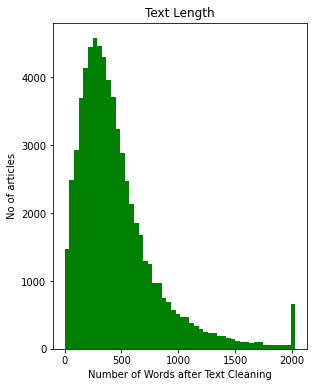

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)

#Tokens Length Plot
plt.hist(tr_cl.len_text, 50, color= "green")
plt.title("Text Length")
plt.xlabel("Number of Words after Text Cleaning")
plt.ylabel("No of articles")

plt.show()

In [ ]:
#post-cleaning
print(tr_cl.text[4])
#pre-cleaning
tr_new = tr_new.reset_index(drop = True)
print(tr_new.text[4])

##changes better to well but best to good

['robotic', 'meditation', 'therapy', 'artificial', 'intelligence', 'feeling', 'robot', 'love', 'well', 'human', 'discuss', 'michelle', 'tsng', 'podcast', 'crazy', 'wisdom', 'say', 'robot', 'love', 'well', 'human', 'no', 'judgement', 'human', 'being', 'particularly', 'one', 'traumatize', 'subconsciously', 'detect', 'judge', 'know', 'true', 'feeling', 'hide', 'people', 'judge', 'good', 'guide', 'find', 'withhold', 'judgmental', 'thought', 'express', 'safe', 'warm', 'loving', 'connection', 'robot', 'sophisticated', 'able', 'provide', 'love', 'warm', 'connection', 'audio', 'clip', 'michelle', 'discuss', 'experience', 'talk', 'sofia', 'robotic', 'companion', 'human', 'being', 'say', 'soon', 'build', 'robot', 'well', 'love', 'human', 'think', 'feel', 'comfortable', 'share', 'intimate', 'experience', 'seek', 'therapeutic', 'treatment', 'robot', 'check', 'interview', 'website']
Robotics, Meditation, Therapy, Artificial Intelligence, Feelings Can a robot love us better than another human can?



Short texts (less than ten tokens) seem to have less claps than longer texts with a few exceptions. However, those exceptions are the mentioned blog posts that contain images with text rather than "scrappable" text.

In [ ]:
tr_cl["text_len"] = [len(x) for x in tr_cl.text.values]
text_short = tr_cl.loc[tr_cl.text_len < 10, ["totalClapCount"]]
text_short.describe()

,totalClapCount
count,102.000000
mean,23.784314
std,94.378281
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,632.000000


**Checkpoint**

In [ ]:
#SAVE cleaned training data file
import pickle
with open("train_cleaned", "wb") as path_name:
  pickle.dump(train_cleaned, path_name)

In [ ]:
#LOAD cleaned training data file
import pickle
with open("train_cleaned", "rb") as path_name:
  tr_cl = pickle.load(path_name)

print(tr_cl.loc[10, "text"])

['artificial', 'intelligence', 'ai', 'impact', 'world', 'actually', 'ai', 'efiicte', 'world', 'good', 'way', 'efficient', 'way', 'go', 'to', 'kill', 'no', 'different', 'job', 'world', 'today', 'go', 'to', 'automate', 'open', 'open', 'no', 'opportunity', 'different', 'job', 'jobs', 'people', 'like', 'current', 'world', 'save', 'complex', 'statistic', 'mathematics', 'didn', 'ai', 'ai', 'get', 'new', 'feature', 'like', 'machine', 'talk', 'like', 'human', 'someday', 'machine', 'not', 'machine', 'human', 'like', 'solve', 'no', 'current', 'problem', 'fear', 'ai', 'apoocylapse', 'not', 'usedsny', 'command', 'line', 'server', 'language', 'programmer', 'know', 'machine', 'way', 'dumb', 'human']


In [ ]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
tr_cl["text_cl"] = [TreebankWordDetokenizer().detokenize(token) for token in tr_cl.text] #needed as an input for afinn and for one-hot-encoding

###Sentiment Analysis

The idea behind conducting a sentiment analysis, even though the scrapped articles were mainly tech related article which are not exactly famous for their emotionality, was that we observed that the very high claps were blog posts with emotional topic such as chronic depression or groundbreaking skills. However, the results were not very promising and thus were not examined any further. For the sake of completeness the brief sentiment is still in the assignment post since I might be an interesting topic for further research.

In [ ]:
a = "totalClapCount > 150000"
highclaps = tr_cl.query(a)
highclaps["title"]

35112    My name is Wil Wheaton. I Live With Chronic De...
38329           The Most Important Skill Nobody Taught You
Name: title, dtype: object

In [ ]:
af = Afinn()
#Afinn - dictionary based results might be biased towards positive articles as the result showed in the tut #11 regarding the reviews of movies.

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for afinn: filename=afinn-0.1-cp36-none-any.whl size=53453 sha256=03608037d68ca8d78fcfbbbc805ec57cbfbf9befd00315a00abda1824dbd53db
  Stored in directory: /root/.cache/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn


In [ ]:
tr_cl["text_cl"] = tr_cl["text_cl"][:400] 

In [ ]:
start = time.time()
tr_cl["sentiment"] = tr_cl["text_cl"].apply(af.score)
end = time.time()

print("Processed {} articles in {:.0f} sec.".format(tr_cl.shape[0], end-start))

In [ ]:
tr_cl["text_len"] = tr_cl.text.apply(len)
#tr_cl["rel_sentiment"] = tr_cl.apply(lambda row: row["sentiment"] / row["text_len"], axis=1)

In [ ]:
tr_cl[["totalClapCount", "sentiment", "text_len", "emotionality"]]

In [ ]:
tr_cl["emotionality"] = np.where((tr_cl["sentiment"] > 70) | (tr_cl["sentiment"] < -70), 1, 0) #1 = very emotional

In [ ]:
tr_cl.emotionality.value_counts()

0    17101
1     2898
Name: emotionality, dtype: int64

In [ ]:
emotional = tr_cl.loc[tr_cl.emotionality == 1, ["totalClapCount"]]
unemotional = tr_cl.loc[tr_cl.emotionality == 0, ["totalClapCount"]]

In [ ]:
#total clap counts of emotional texts
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(emotional.totalClapCount, 200, color = "green", density = True , range = (10,400))
plt.title("Total Clap Counts of emotional articles")
plt.xlabel("# of Claps")
#total clap counts of less emotional texts
plt.subplot(1, 2, 2)
plt.hist(unemotional.totalClapCount, 200,color = "darkorange", density = True , range = (10,400))
plt.title("Total clap counts of less emotional texts")
plt.xlabel("# of Claps")
plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()

In [ ]:
highclaps = tr_cl.loc[tr_cl.totalClapCount > 30000, ["totalClapCount", "emotionality", "sentiment", "title"]]
highclaps

,totalClapCount,emotionality,sentiment,title
590,47445.0,0,23.0,Learning Python: From Zero to Hero
2930,39376.0,0,13.0,Want to know how Deep Learning works? Here’s a...
5729,49838.0,0,21.0,I interviewed at five top companies in Silicon...
12640,79766.0,0,9.0,Towards a Bra-free Instagram Experience
14560,33856.0,0,12.0,The Snips AIR Token Sale
16485,112595.0,0,-2.0,We fired our top talent. Best decision we ever...
17956,32693.0,0,30.0,What exactly can you do with Python? Here are ...
18499,42710.0,0,27.0,Fast-forward twenty years with Anything App.
19092,35192.0,0,-14.0,Cognitive bias cheat sheet


In [ ]:
neg_senti = tr_cl.loc[tr_cl.sentiment < -80, ["totalClapCount", "emotionality", "sentiment", "title"]]
neg_senti #very negative sentiment has barely any claps

,totalClapCount,emotionality,sentiment,title
663,2.0,1,-100.0,Fraud Detection with ML
2936,0.0,1,-156.0,Pdf Download eBook Free Fraud Analytics Using ...
7065,0.0,1,-160.0,Download pdf Online No bullshit guide to linea...
9759,0.0,1,-111.0,Fraud Management: Detection and Prevention in ...
14490,0.0,1,-84.0,Google is Using its AI to Track U.S. Hate Crimes
18784,0.0,1,-87.0,Why Every Business Needs Fraud Analytics


In [ ]:
pos_senti = tr_cl.loc[tr_cl.sentiment > 80, ["totalClapCount", "emotionality", "sentiment", "title"]]
pos_senti #very negative sentiment has barely any claps

,totalClapCount,emotionality,sentiment,title
2225,0.0,1,81.0,Introducing “NEVA” by NICE — The First Robotic...
3706,5.0,1,114.0,We analyzed historical Super Bowl data and fou...
4776,0.0,1,110.0,Pdf download Journey to Data Scientist: Interv...
4996,234.0,1,88.0,Artificial Intelligence (AI) In Beauty Industry
8480,0.0,1,96.0,Download pdf Read Online Howl’s Moving Castle ...
9405,526.0,1,87.0,Free game-analytics on moreMMR.com VS DotA Plus
11582,0.0,1,96.0,Read Artificial Intelligence: A Guide To Intel...
12240,0.0,1,90.0,buy elo boost
13038,0.0,1,99.0,Tips on How to Hire an Artificial Intelligence...
14387,106.0,1,83.0,"2017 in review — startups, bots & AI"


In [ ]:
print(np.corrcoef(tr_cl.totalClapCount, tr_cl.sentiment))
#print(np.corrcoef(tr_cl.totalClapCount, tr_cl.rel_sentiment))
print(np.corrcoef(tr_cl.totalClapCount, tr_cl.text_len))
#validation check: should be somewhat positive correlated 
print(np.corrcoef(tr_cl.text_len, tr_cl.sentiment))

[[ 1.         -0.00419232]
 [-0.00419232  1.        ]]
[[1.         0.02545214]
 [0.02545214 1.        ]]
[[1.         0.21701534]
 [0.21701534 1.        ]]


## Embeddings

Before feeding the words to a neural network with the target of predicting the clap scores, the words of the blog posts can be be transformed into number in order to keep information about the relation between words, e.g. how similar a word is to another or the co-occurence of words. This is either possible with pre-trained embedding as well as with "self-trained" embeddings. The goal is to catch the semantic as well as syntatic relationship between words. Both option will be applied and compared. <br>
Training own embeddings is computationally very costly and can take up a long time. Furthermore, it is dependend on the amount and quality of the training data, the used algorithm and the size of the vectors. The underlying hardware has a significant impact and sets limitation on the choice of the parameters of the algorithm such as the dimensions of the vector. However, the upside of this approach is that the word embeddings are tailored to solve a task with exactly the underlying kind of data. In contrast, pre-trained embeddings contain huge amounts of data in their embeddings. But, they might be trained on different kinds of data and therefore, might be outperformed by the self-trained embeddings. It is possible to fine-tune them with the target corpus. [4] <br>


In [ ]:
X = tr_cl.loc[:,["text"]] 
y = tr_cl.loc[:,["totalClapCount"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) #random state for comparability

In [ ]:
word_counter = collections.Counter()
for r in X_train["text"]:
  for w in r:
    word_counter.update({w: 1})

In [ ]:
#most common words occuring in the text corpus of X_train
word_counter.most_common(25)

[('data', 360322),
 ('ai', 199470),
 ('not', 175814),
 ('learn', 152833),
 ('machine', 149704),
 ('model', 131426),
 ('time', 116843),
 ('use', 107613),
 ('like', 106578),
 ('intelligence', 100385),
 ('work', 98651),
 ('learning', 93021),
 ('new', 92458),
 ('human', 90804),
 ('technology', 87100),
 ('artificial', 85584),
 ('need', 84517),
 ('way', 73486),
 ('network', 72830),
 ('create', 70346),
 ('people', 69399),
 ('good', 68987),
 ('system', 68262),
 ('company', 66180),
 ('user', 66115)]

### Self-trained Embeddings

A famous method for creating word embeddings is Word2Vec. Word2Vec inherits two methods that work slightly different. They are called Skip-Gram (SG) and Common Bag of Words (CBOW). Both are based on neural networks. [4] <br> Skip-gram is slower than cbow but it is more suitable for infrequent words. Both algorithms will be tested with the similar parameter (except window size) in order to be able to compare them. Setting the hyper-parameter is essential for the performance and the accuracy of the resulting embedding. Google suggests to set the window size for cbow to 5 and for skip-gram to 10. The hierarchical softmax function provides better results for infrequent words. In contrast, the negative sampling is more suitable for frequent words but also for vectors with low dimensions. In general, the most dimensions the better. [1] Unfortunately, the computing PC has computational limitations.
<br> Often only unigram approaches are applied. However, in the contest of the analysis many important bigrams occur such as artificial intelligence and data science. In order to obtain those bigrams we include the bigram tokens in our analysis. <br>
Both models are trained 25 epochs with an embedding dimension with 150 and 300. In the following both models will explained in more detail. <br> 


####Preparation of Bigram Tokens

In [ ]:
#including bigrams to word embedding; some unneccessary bigram which do not contribute anything to the word embedding quality
#however, very important bigrams such as artificial intelligent etc. are included which contribute a lot; as it can be observed
#in the most frequent words the first 10 bigrams are very meaningful regarding the context
bigram_model = Phrases(X_train["text"], min_count=100, threshold=2, delimiter=b"_")
bigram_phraser = Phraser(bigram_model)

bigram_token = []
for x in X_train["text"]:
    bigram_token.append(bigram_phraser[x])

In [ ]:
#count bigrams
bigram_counter = collections.Counter()
for key in bigram_model.vocab.keys():
  if key.decode().find("_")>-1:
    bigram_counter[key] += bigram_model.vocab[key]

In [ ]:
bigram_counter.most_common(25)

[(b'artificial_intelligence', 78673),
 (b'machine_learning', 54116),
 (b'machine_learn', 52847),
 (b'data_science', 44161),
 (b'neural_network', 33346),
 (b'deep_learn', 19734),
 (b'data_scientist', 17342),
 (b'deep_learning', 16678),
 (b'big_data', 14431),
 (b'data_set', 11296),
 (b'natural_language', 9291),
 (b'real_time', 8935),
 (b'look_like', 8196),
 (b'social_medium', 7770),
 (b'use_case', 6998),
 (b'open_source', 6602),
 (b'computer_vision', 6536),
 (b'learning_model', 6529),
 (b'training_data', 6520),
 (b'data_analysis', 6514),
 (b'real_world', 6071),
 (b'intelligence_ai', 5886),
 (b'language_processing', 5423),
 (b'linear_regression', 5410),
 (b'learn_artificial', 5309)]

####Skip-gram Model

The skip-gram approach loops over the each word of the corpus aka the input sequence and tries to predict the neighboring words which are the representation of the context. How many neighboring words is dependend on the parameter "window_size". If the window size is e.g. 5, the model tries to predict the two words in front and behind the target word. The model is trained on a one layer neural network. [5]

In [ ]:
epochs = 25

t1 = time.perf_counter()
model_sg_bigram = Word2Vec(bigram_token,
                 min_count = 5,## min_count means the frequency benchmark, if =2 and word is used only once - it's not included
                 sg = 1, #trains for skip-gram (tut: CBOW by default, we have to add it to specify for skipgram)
                 window = 10, #the size of context
                 iter = epochs, #how many times the training code will run through the data set, same as epochs (first pass is to create dict)
                 size = 150, #size of embedding
                 workers = 4, #for parallel computing
                 hs = 0) #0 for negative sampling; 1 for softmax function
    
t2 = time.perf_counter()
t3_sg_bigram = (t2-t1)/60
print(model_sg_bigram)
print("The computation of the embedding for the skip-gram model took {:.2f} minutes.".format(t3_sg_bigram))

#with epoch = 15, size = 150
#Word2Vec(vocab=58073, size=150, alpha=0.025)
#The computation of the embedding for the skip-gram model took 81.55 minutes.

#with epoch = 25, size = 300
#Word2Vec(vocab=58073, size=300, alpha=0.025)
#The computation of the embedding for the skip-gram model took 159.33 minutes.

#with epoch = 25, size = 300
#Word2Vec(vocab=64334, size=300, alpha=0.025)
#The computation of the embedding for the skip-gram model took 179.85 minutes.

#with epoch = 25, size = 300
#Word2Vec(vocab=64334, size=150, alpha=0.025)
#The computation of the embedding for the skip-gram model took 150.50 minutes.

Word2Vec(vocab=64334, size=150, alpha=0.025)
The computation of the embedding for the skip-gram model took 150.50 minutes.


In [ ]:
#results: 150
print(model_sg_bigram.wv.vectors.shape)
model_sg_bigram.wv.most_similar(positive=["good"], topn = 10) 

(64334, 150)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('best', 0.7949308156967163),
 ('well', 0.7241239547729492),
 ('better', 0.6603259444236755),
 ('bad', 0.6512195467948914),
 ('great', 0.646959125995636),
 ('perfect', 0.6388470530509949),
 ('excellent', 0.6254705786705017),
 ('decent', 0.6192342042922974),
 ('not', 0.6097713112831116),
 ('want', 0.6087747812271118)]

In [ ]:
#results: 300
print(model_sg_bigram.wv.vectors.shape)
model_sg_bigram.wv.most_similar(positive=["good"], topn = 10) #model seems to catch the meaning very well

(64334, 300)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('best', 0.6863915324211121),
 ('well', 0.6473300457000732),
 ('bad', 0.596216082572937),
 ('excellent', 0.5689988732337952),
 ('great', 0.5610009431838989),
 ('better', 0.5605751872062683),
 ('perfect', 0.533531665802002),
 ('find_good', 0.5205310583114624),
 ('decent', 0.5025161504745483),
 ('want', 0.49737104773521423)]

Saving

In [ ]:
#saving
embs="sg_150_bigram_embeddings.txt"
model_sg_bigram.wv.save_word2vec_format(embs, binary=False)
#embs="sg_300_bigram_embeddings.txt"
#model_sg_bigram.wv.save_word2vec_format(embs, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


####Cbow Model (Word2Vec)

The CBOW model works similar to the skip-gram model just the other way around. Instead of predicting the neighboring words, it uses the neighboring words in order to predict the target word. [5]

In [ ]:
epochs = 25

t1 = time.perf_counter()
model_cbow_bigram = Word2Vec(bigram_token,
                 min_count = 5, # min_count means the frequency benchmark, if =2 and word is used only once - it's not included
                 sg = 0, #trains for skip-gram (tut: CBOW by default, we have to add it to specify for skipgram)
                 window = 5, #the size of context
                 iter = epochs, #how many times the training code will run through the data set, same as epochs (first pass is to create dict)
                 size = 300, #size of embedding
                 workers = 4, #for parallel computing
                 hs = 0) #0 for negative sampling; 1 for softmax function
    
t2 = time.perf_counter()
t3_cbow_bigram = (t2-t1)/60
print(model_cbow_bigram)
print("The computation of the embedding for the cbow model took {:.2f} minutes.".format(t3_cbow_bigram))

#Word2Vec(vocab=56943, size=150, alpha=0.025)
#The computation of the embedding for the cbow model took 20.29 minutes.

#Word2Vec(vocab=56943, size=300, alpha=0.025)
#The computation of the embedding for the cbow model took 22.09 minutes.

#Word2Vec(vocab=64334, size=300, alpha=0.025)
#The computation of the embedding for the cbow model took 27.93 minutes.

Word2Vec(vocab=64334, size=300, alpha=0.025)
The computation of the embedding for the cbow model took 27.93 minutes.


In [ ]:
#saving (depending on the further use both types of saving can be useful)

embs="cbow_300_bigram_embeddings.txt"
model_cbow_bigram.wv.save_word2vec_format(embs, binary=False)

embs_cbow_bigram = "w2v_article_text_embeddings_cbow_e25_s300.model"
model_cbow_bigram.wv.save_word2vec_format(embs_cbow_bigram, binary = False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
print(model_cbow_bigram.wv.vectors.shape)
model_cbow_bigram.wv.most_similar(positive=["good"], topn = 10) 

(64334, 300)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('well', 0.5801551342010498),
 ('best', 0.5796145796775818),
 ('pretty_good', 0.5109511613845825),
 ('perfect', 0.5035198926925659),
 ('find_good', 0.48832467198371887),
 ('decent', 0.4844015836715698),
 ('great', 0.4740249812602997),
 ('bad', 0.4659029543399811),
 ('want', 0.45844513177871704),
 ('good_way', 0.4515240788459778)]

In [ ]:
print(model_cbow_bigram.wv.vectors.shape)
model_cbow_bigram.wv.most_similar(positive=["ai"], topn = 10) 

(64334, 300)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('artificial_intelligence', 0.7699136734008789),
 ('technology', 0.6802035570144653),
 ('ai_ml', 0.5772320032119751),
 ('new_technology', 0.531817615032196),
 ('cognitive_technology', 0.5301433801651001),
 ('advance_ai', 0.5288519859313965),
 ('automation', 0.5155724287033081),
 ('intelligent_machine', 0.510002613067627),
 ('ai_technologies', 0.4944221079349518),
 ('narrow_ai', 0.4883231222629547)]

In [ ]:
epochs = 25

t1 = time.perf_counter()
model_cbow_bigram = Word2Vec(bigram_token,
                 min_count = 5, # min_count means the frequency benchmark, if =2 and word is used only once - it's not included
                 sg = 0, #trains for skip-gram (tut: CBOW by default, we have to add it to specify for skipgram)
                 window = 5, #the size of context
                 iter = epochs, #how many times the training code will run through the data set, same as epochs (first pass is to create dict)
                 size = 150, #size of embedding
                 workers = 4, #for parallel computing
                 hs = 0) #0 for negative sampling; 1 for softmax function
    
t2 = time.perf_counter()
t3_cbow_bigram = (t2-t1)/60
print(model_cbow_bigram)
print("The computation of the embedding for the cbow model took {:.2f} minutes.".format(t3_cbow_bigram))

#Word2Vec(vocab=56943, size=150, alpha=0.025)
#The computation of the embedding for the cbow model took 20.29 minutes.

#Word2Vec(vocab=56943, size=300, alpha=0.025)
#The computation of the embedding for the cbow model took 22.09 minutes.

#Word2Vec(vocab=64334, size=150, alpha=0.025)
#The computation of the embedding for the cbow model took 23.69 minutes.

Word2Vec(vocab=64334, size=150, alpha=0.025)
The computation of the embedding for the cbow model took 23.69 minutes.


In [ ]:
#saving
embs="cbow_150_bigram_embeddings.txt"
model_cbow_bigram.wv.save_word2vec_format(embs, binary=False)

embs_cbow_bigram = "w2v_article_text_embeddings_cbow_e25_s150.model"
model_cbow_bigram.wv.save_word2vec_format(embs_cbow_bigram, binary = False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
print(model_cbow_bigram.wv.vectors.shape)
model_cbow_bigram.wv.most_similar(positive=["good"], topn = 10) 

(64334, 150)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('well', 0.6915244460105896),
 ('best', 0.6755548715591431),
 ('perfect', 0.6312260627746582),
 ('pretty_good', 0.6138462424278259),
 ('great', 0.5810209512710571),
 ('decent', 0.5731098651885986),
 ('better', 0.5647061467170715),
 ('bad', 0.5459110140800476),
 ('find_good', 0.5434296727180481),
 ('want', 0.5409783124923706)]

### Pre-trained Embeddings

As a pre-trained embedding we used GloVe which is trained by Stanford and publicly accessible. The training of GloVe is performed with an unsupervised machine model on "aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space" [6].
<br>The corpus that we downloaded and used was trained on Wikipedia 2014 + Gigaword 5. It contains 400.000 tokens. We decided on the Wikipedia trained version since it is the most similar to the underlying data. It is a public blog where professionals and non-professionals published condensed information. The word embedding has 300 dimensions which is needed for comparability.
<br> 
A drawback of this model might be that it is not trained on bigrams.


In [ ]:
glove_emb_index = {}

file = open(os.getcwd() + "/" + "glove.6B.300d.txt", encoding = "utf-8")
for line in file:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype = "float32")
  embeddings_index[word] = coefs
file.close()

##Implementation of Prediction Models

In the following chapter we will implement an Elastic Net as a baseline model as a benchmark. Afterwards all word embeddings will be evaluate applied to a GRU architecture in order to decide with which word embedding we want to train our prediction models.

**Checkpoint**

In [ ]:
#load new training data file
with open("train_cleaned", "rb") as path_name:
  tr_cl = pickle.load(path_name)

print(tr_cl.loc[10, "text"])

['artificial', 'intelligence', 'ai', 'impact', 'world', 'actually', 'ai', 'efiicte', 'world', 'good', 'way', 'efficient', 'way', 'go', 'to', 'kill', 'no', 'different', 'job', 'world', 'today', 'go', 'to', 'automate', 'open', 'open', 'no', 'opportunity', 'different', 'job', 'jobs', 'people', 'like', 'current', 'world', 'save', 'complex', 'statistic', 'mathematics', 'didn', 'ai', 'ai', 'get', 'new', 'feature', 'like', 'machine', 'talk', 'like', 'human', 'someday', 'machine', 'not', 'machine', 'human', 'like', 'solve', 'no', 'current', 'problem', 'fear', 'ai', 'apoocylapse', 'not', 'usedsny', 'command', 'line', 'server', 'language', 'programmer', 'know', 'machine', 'way', 'dumb', 'human']


###Data Preparation for Prediction

In [ ]:
#LOAD data
X = tr_cl.loc[:,["text"]] 
#X = tr_cl.drop(["totalClapCount"], axis = 1) 
y = tr_cl.loc[:,["totalClapCount"]]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=123) 
#test data are 20 % of the full data set
#the seed 123 is provided for comparability of the results since I will test different approaches

In [ ]:
print(X.shape)
print(y.shape)

(66380, 1)
(66380, 1)


In [ ]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) #random state for comparability

In [ ]:
#train

#tokenize texts to sequence (NNs only take numerical values as inputs and no strings)
tokenizer_obj_train = Tokenizer() #vectorizes the text corpus
tokenizer_obj_train.fit_on_texts(X_train["text"])
seq_train = tokenizer_obj_train.texts_to_sequences(X_train["text"])

max_text_len = 400

#the length of the word index holds the number of unique tokens in the data set
word_index = tokenizer_obj_train.word_index
print("Unique tokens: {:,.0f} ".format(len(word_index)))
word_index_train = word_index

#"filling up" embeddings with a text length less than the max text length of 427 with 0s
X_train = pad_sequences(seq_train, max_text_len) 
print(X_train.shape) #(number of text (rows), number of max length of a sequence)

Unique tokens: 205,741 
(53104, 400)


In [ ]:
#test

#tokenize texts to sequence (NNs only take numerical values as inputs and no strings)
tokenizer_obj_test = Tokenizer() #vectorizes the text corpus
tokenizer_obj_test.fit_on_texts(X_test["text"])
seq_test = tokenizer_obj_test.texts_to_sequences(X_test["text"])

#the length of the word index holds the number of unique tokens in the data set
word_index_test = tokenizer_obj_test.word_index  #word_index contains vector words (shape: 1 x number of unique tokens)
print("Unique tokens: {:,.0f} ".format(len(word_index_test)))

#"filling up" embeddings with a text length less than the max text length of 427 with 0s
X_test = pad_sequences(seq_test, max_text_len) 
print(X_test.shape) #(number of text (rows), number of max length of a sequence)

Unique tokens: 93,945 
(13276, 400)


As already stated in the first part of the analysis, the target variable contains extreme values. Therefore, we decided to make a commom outlier cut at 3*Interquartile-Range (IQR). Hence, our model will not be able to calculate a huge number of claps but will train better and more common observations.

In [ ]:
Q1 = np.percentile(y_train["totalClapCount"], 25, interpolation = 'midpoint') 
Q3 = np.percentile(y_train["totalClapCount"], 75, interpolation = 'midpoint') 
IQR = Q3 - Q1
cutoff = IQR * 3
claps = np.clip(y_train["totalClapCount"], 0, cutoff)
y_train["totalClapCount"] = claps
y_train["totalClapCount"].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count    53104.000000
mean        46.330521
std         68.312569
min          0.000000
25%          0.000000
50%          6.000000
75%         65.000000
max        195.000000
Name: totalClapCount, dtype: float64

**Other Variables**

In [ ]:
X = tr_cl.loc[:,["author", "responsesCreatedCount", "totalClapCount"]] #the target variable totalClapCount is needed in order to compute the target encoding and will be removed later on

In [ ]:
X_train_var, X_test_var = train_test_split(X, test_size=0.2, random_state=123)

In [ ]:
#target encoding
#https://maxhalford.github.io/blog/target-encoding/

X_train_var["author"] = X_train_var["author"].map(X_train_var.groupby("author")["totalClapCount"].mean())
X_test_var["author"] = X_test_var["author"].map(X_test_var.groupby("author")["totalClapCount"].mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
X_train_var = X_train_var.drop(columns = "totalClapCount")
X_test_var = X_test_var.drop(columns = "totalClapCount")

In [ ]:
X_train_var = X_train_var[["author", "responsesCreatedCount"]].values
X_test_var = X_test_var[["author", "responsesCreatedCount"]].values

In [ ]:
X_train_var.shape

(53104, 2)

In [ ]:
scale = StandardScaler().fit(X_train_var)

X_train_var_scaled = scale.transform(X_train_var)
X_test_var_scaled = scale.transform(X_test_var)

In [ ]:
#Input for models
X_train = np.concatenate((X_train, X_train_var_scaled), axis=1)
X_test = np.concatenate((X_test, X_test_var_scaled), axis=1)

In [ ]:
print(X_train.shape, X_test.shape)

(53104, 402) (13276, 402)


###Benchmark Model

As a model to benchmark the performance of the other models we choose an elastic net. Elastic Net is linear model but it also applies regularization. It can be a mixture of Lasso and Ridge depending on the parameter l1_ratio. If it is 1 than an Elastic Net is equal to Lasso and with a l1_ratio equal to 0, it is a Ridge Model. Elastic Net is suitable if the dimension are high and the assumption of unnecessary features. [7]

In [ ]:
models = {}

We applied parameter tuning with grid search in order to optimize the basic model since it will compete with more sophisticated models later on. To reduce the chance of overfitting, a 10-fold crossvalidation is performed.

In [ ]:
#tune parameters of model with grid search
parametersGrid = {"max_iter": [1, 5, 10],
                  "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  "l1_ratio": np.arange(0.0, 1.0, 0.1)} #l1-ration: 0 = ridge, 1 = lasso

model = ElasticNet(tol = 1) #otherwise: "ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations"
grid = GridSearchCV(model, parametersGrid, cv=10)
grid = grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

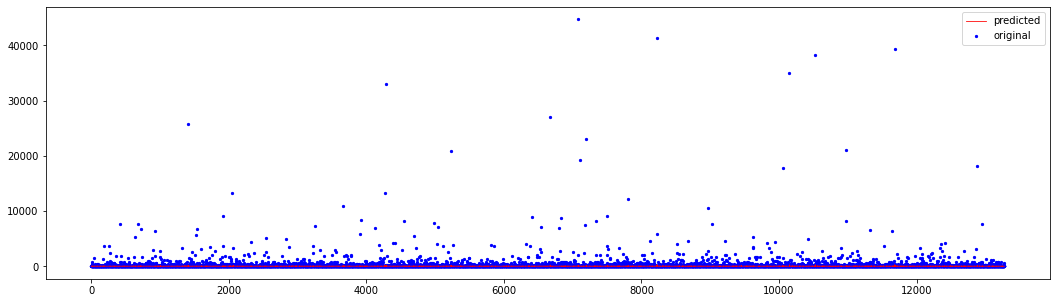

In [ ]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [ ]:
grid.best_params_

{'alpha': 1, 'l1_ratio': 0.7000000000000001, 'max_iter': 5}

In [ ]:
mse_en_grid = mean_squared_error(y_test, y_pred)

In [ ]:
models.update({"ElastricNet_Grid" : mse_en_grid})

In [ ]:
models

{'ElastricNet_Grid': 1243992.2881074175}

###Evaluation of Word Embeddings



####Preparation for Evaluation

**Loading Functions**

In [ ]:
def load_embedding(file):
  
    embeddings_index = {}
    file = open(file, encoding = "utf-8")
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = "float32")
        embeddings_index[word] = coefs
    file.close()

    return embeddings_index

An embedding matrix functions as a lookup table for input words. The embedding of a word , e.g. "data", has an index i which can be "looked up" in the $i^{th}$ row of the embedding matrix. Hence, we match the word indexes with the embedding matrix. An embedding matrix can be used as input for the training of a neural network. <p>The code of the following function is inspired by the [code]({https://github.com/stefanlessmann/adams/blob/master/exercises/Ex11_GRU_GloVe/Ex11%20sentiment_analysis.ipynb}) given in lecture 11 of the ADAM course by Prof. Lessmann (HU zu Berlin). 

In [ ]:
#word_index = word_index from tokenizer (it the same for all following NN-models)
#embedding_index = loaded word embedding
#dim = size of word embedding
#num_words should be the length of the word index + 1 for collection the unknown words which will be represented by 0s in the embedding matrix

def generate_emb_mat(word_index, embedding_index, dim):
    
    num_words = len(word_index) + 1
    embedding_matrix = np.zeros((num_words, dim))

    for word, i in word_index.items():
        if i > num_words:
            continue
      
        try:
            embedding_vector = embedding_index.get(word)
        except:
            embedding_vector = embedding_index.word_vectors[embedding_index.dictionary[word]]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        
    return embedding_matrix

In [ ]:
def plot_hist(model_hist):
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    
    #show training loss
    plt.plot(model_hist.history["loss"], color="green")
    plt.title("model loss")
    plt.ylabel("MSE")
    plt.xlabel("epoch")
    plt.legend(["train"], loc="upper right")

    #show validation loss
    plt.subplot(1, 2, 2)
    plt.plot(model_hist.history["val_loss"], color = "orange")
    plt.title("validation loss")
    plt.ylabel("MSE")
    plt.xlabel("epoch")
    plt.legend(["val"], loc="upper right")
    plt.subplots_adjust(bottom=0.25, top=0.75)

    return plt.show()

In [ ]:
#Method/Function for training a GRU model and making a prediction (besides calling the function for generating the embedding matrix)
#No trainable features

#dim = size of the embedding (150 or 300)
#emb_mat = generated embedding matrix
#name = for naming the produced scores etc. (e.g. cbow150)
#word_index = needed for the gen_embed_matrix function

def GRU_embed_models(embedding_index, name, word_index, dim):
  
  emb_mat = generate_emb_mat(word_index, embedding_index, dim) 
  
  print("Training the GRU with a pretrained {}-embedding".format(name))

  #embedding layer
  embedding_layer = Embedding(input_dim = no_of_words,
                            output_dim = dim,
                            input_length = max_text_len,
                            embeddings_initializer = Constant(emb_mat),
                            trainable = False)

  #GRU set up
  model = Sequential()
  model.add(embedding_layer)
  model.add(GRU(100))
  model.add(Dense(1, activation = "relu"))
  model.compile(loss = "mse", optimizer = "adam")#, metrics = ["mae"])
  model.summary()

  #train
  model_hist_GRU = model.fit(X_train, y_train, validation_split = val_split, epochs= epochs, batch_size = batch_size) #validation_data=(x_val, y_val)

  #save weights
  GRU_w_up = model.layers[1].get_weights()
  model.save_weights("GRU_" + name + "_10ep_64ba.h5")
  print("Saving successful")

  #show
  plot_hist(model_hist_GRU)

  #evaluate and predict
  scores = model.evaluate(X_test, y_test, verbose = 0)
  #print("The loss is: {}".format(scores[0])) #loss and mae
  #print("The MAE is: {:.2f}".format(scores[1])) 
  y_pred = model.predict(X_test)

  GRU_models.update({name + " MSE": mean_squared_error(y_test, y_pred)})
  GRU_models_hist.update({name: model_hist_GRU.history})

  return scores, model_hist_GRU.history

In [ ]:
#loading pretrained embedding matrices
cbow150_emb_index = load_embedding(os.getcwd() + "/" + "cbow_150_bigram_embeddings.txt")
cbow300_emb_index = load_embedding(os.getcwd() + "/" + "cbow_300_bigram_embeddings.txt")
sg150_emb_index = load_embedding(os.getcwd() + "/" + "sg_150_bigram_embeddings.txt")
sg300_emb_index = load_embedding(os.getcwd() + "/" + "sg_300_bigram_embeddings.txt")

glove_emb_index = load_embedding(os.getcwd() + "/" + "glove.6B.300d.txt")
#not working this way: news_emb_index = load_embedding(os.getcwd() + "/" + "GoogleNews-vectors-negative300.bin")

#print("The embedding contains {} word vectors".format(len(cbow_emb_index)))

In [ ]:
print(len(cbow150_emb_index))
print(len(cbow300_emb_index))
print(len(sg150_emb_index))
print(len(sg300_emb_index))
print(len(glove_emb_index))

64335
64335
64335
64335
400000


With help of the parameter "embeddings_initializer" and the keras function "Constant", an pretrained embedding matrix can be used as an input for the embedding layer. If not, embedding weights are initialized. The function "embedding" assigns by default randomly weights to the given words by using an uniform distribution. The parameter "trainable" controlls which weights will be trained and which will be frozen. Setting this parameter to false speeds up training since less parameters have to be trained (see model summary non-trainable parameters) and the problem of a vanishing gradient is less present. Nevertheless, the trained models performed better with updating the weights during training.<p>
In preparation for this model, the weights of the pretrained cbow word embedding matrix were trained on the model. This updated weights are used in the following model in order to fine-tune the results of the GRU model.

**Set Parameters**

In [ ]:
#set parameters

no_of_words = len(tokenizer_obj_train.word_index)+1 #number of unique words in the embedding plus one for unknown tokens
max_text_len = 400 #take only the first 400 words per article
nb_hidden = 100
epochs = 10
batch_size = 128
val_split = 0.25

In [ ]:
no_of_words

205742

####Application of Word Embeddings

All word embeddings will be trained on a non-trainable GRU architecture with 10 epochs. Even though 10 epochs is not very big, it is sufficient for the task of evaluation the different performances of the word embeddings because the validation losses stop dropping after this period for all word embeddings<br> The MSE of each model is summed up in the subchapter results.

In [ ]:
GRU_models = {}
GRU_models_hist = {}

Training the GRU with a pretrained cbow150-embedding
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 400, 150)          34813350  
_________________________________________________________________
gru_8 (GRU)                  (None, 100)               75600     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 34,889,051
Trainable params: 75,701
Non-trainable params: 34,813,350
_________________________________________________________________
Epoch 1/10
623/623 [==============================] - 303s 487ms/step - loss: 4966.9668 - val_loss: 4407.6982
Epoch 2/10
623/623 [==============================] - 307s 493ms/step - loss: 4072.6179 - val_loss: 3767.0737
Epoch 3/10
623/623 [==============================] - 304s 488ms/step - loss: 3691.6062 - val

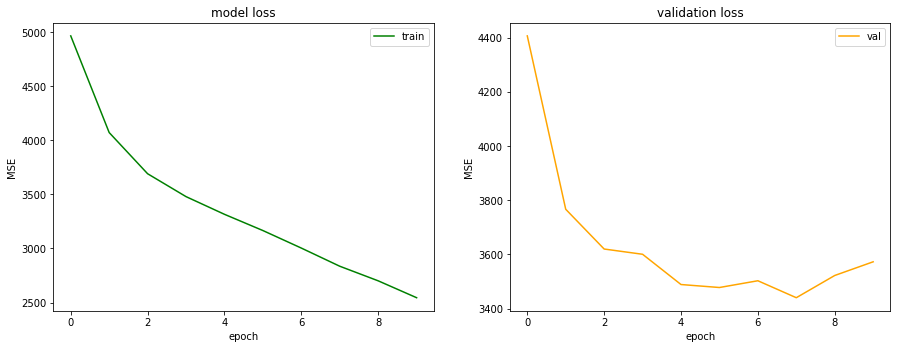

(1246689.75,
 {'loss': [4966.966796875,
   4072.617919921875,
   3691.606201171875,
   3479.74609375,
   3316.152099609375,
   3166.005615234375,
   3003.760986328125,
   2835.797119140625,
   2700.792724609375,
   2544.5322265625],
  'val_loss': [4407.6982421875,
   3767.07373046875,
   3620.12646484375,
   3600.748046875,
   3488.942138671875,
   3477.931640625,
   3502.8896484375,
   3440.2314453125,
   3522.35107421875,
   3572.930908203125]})

In [ ]:
#cbow150
GRU_embed_models(cbow150_emb_index, "cbow150", word_index, 150)
#pretrained w2v
#embed_models_notrain(cbow150_emb_index, "cbow150", word_index, 150)

Training the GRU with a pretrained cbow300-embedding
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 400, 300)          69626700  
_________________________________________________________________
gru_9 (GRU)                  (None, 100)               120600    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 69,747,401
Trainable params: 120,701
Non-trainable params: 69,626,700
_________________________________________________________________
Epoch 1/10
623/623 [==============================] - 415s 666ms/step - loss: 4949.6353 - val_loss: 4275.0791
Epoch 2/10
623/623 [==============================] - 419s 673ms/step - loss: 4027.7305 - val_loss: 3720.2024
Epoch 3/10
623/623 [==============================] - 416s 667ms/step - loss: 3604.8821 - va

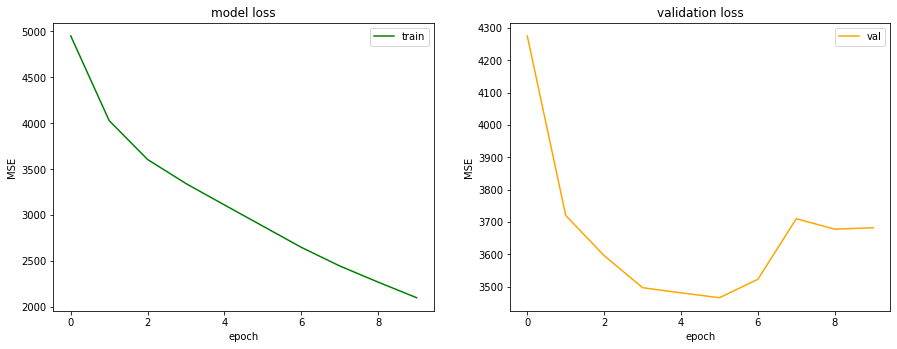

(1244447.625,
 {'loss': [4949.63525390625,
   4027.73046875,
   3604.882080078125,
   3342.76953125,
   3110.20458984375,
   2879.895263671875,
   2649.1748046875,
   2446.568359375,
   2270.59033203125,
   2101.216064453125],
  'val_loss': [4275.0791015625,
   3720.202392578125,
   3595.909912109375,
   3496.89111328125,
   3480.901123046875,
   3465.91943359375,
   3522.8515625,
   3710.0400390625,
   3677.75244140625,
   3682.215087890625]})

In [ ]:
#cbow300
GRU_embed_models(cbow300_emb_index, "cbow300", word_index, 300)

Training the GRU with a pretrained sg150-embedding
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 150)          34813350  
_________________________________________________________________
gru (GRU)                    (None, 100)               75600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 34,889,051
Trainable params: 75,701
Non-trainable params: 34,813,350
_________________________________________________________________
Epoch 1/10
623/623 [==============================] - 300s 481ms/step - loss: 5012.7129 - val_loss: 4568.1396
Epoch 2/10
623/623 [==============================] - 305s 490ms/step - loss: 4700.3833 - val_loss: 4564.0327
Epoch 3/10
623/623 [==============================] - 300s 482ms/step - loss: 5289.3315 - val_loss

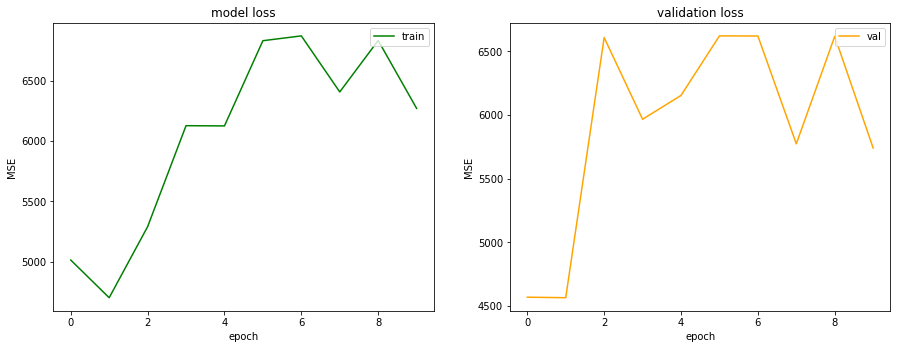

(1263030.0,
 {'loss': [5012.712890625,
   4700.38330078125,
   5289.33154296875,
   6127.4755859375,
   6125.53173828125,
   6832.3984375,
   6872.32763671875,
   6407.474609375,
   6834.3466796875,
   6270.83642578125],
  'val_loss': [4568.1396484375,
   4564.03271484375,
   6609.26318359375,
   5966.9013671875,
   6154.17431640625,
   6622.23095703125,
   6621.48828125,
   5773.80908203125,
   6618.25732421875,
   5740.642578125]})

In [ ]:
#sg150
GRU_embed_models(sg150_emb_index, "sg150", word_index, 150)

Training the GRU with a pretrained sg300-embedding
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 300)          69626700  
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               120600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 69,747,401
Trainable params: 120,701
Non-trainable params: 69,626,700
_________________________________________________________________
Epoch 1/10
623/623 [==============================] - 424s 680ms/step - loss: 4977.9497 - val_loss: 4567.2534
Epoch 2/10
623/623 [==============================] - 416s 668ms/step - loss: 4694.2432 - val_loss: 4514.7583
Epoch 3/10
623/623 [==============================] - 416s 667ms/step - loss: 4222.0552 - val_l

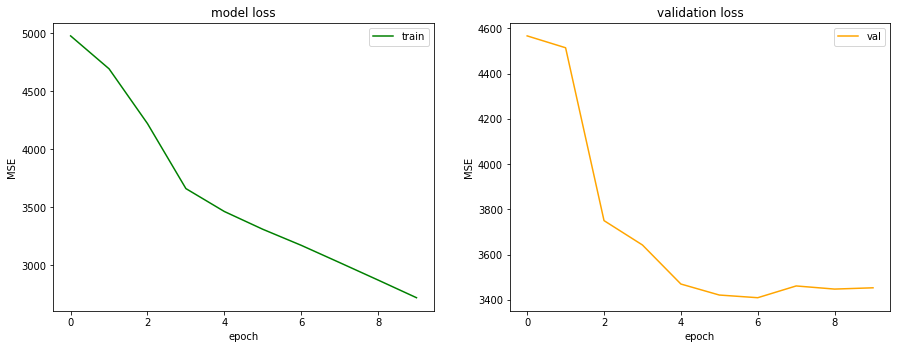

(1247335.875,
 {'loss': [4977.94970703125,
   4694.2431640625,
   4222.05517578125,
   3661.639404296875,
   3464.272705078125,
   3311.090087890625,
   3172.8095703125,
   3023.77294921875,
   2873.407470703125,
   2721.09521484375],
  'val_loss': [4567.25341796875,
   4514.75830078125,
   3750.300048828125,
   3642.498046875,
   3469.90234375,
   3421.19677734375,
   3409.36669921875,
   3461.377197265625,
   3447.515869140625,
   3453.1865234375]})

In [ ]:
#sg300
GRU_embed_models(sg300_emb_index, "sg300", word_index, 300)

Training the GRU with a pretrained glove300-embedding
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 300)          69626700  
_________________________________________________________________
gru_2 (GRU)                  (None, 100)               120600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 69,747,401
Trainable params: 120,701
Non-trainable params: 69,626,700
_________________________________________________________________
Epoch 1/10
623/623 [==============================] - 415s 667ms/step - loss: 4979.5283 - val_loss: 4557.9258
Epoch 2/10
623/623 [==============================] - 414s 664ms/step - loss: 4574.3379 - val_loss: 4127.1904
Epoch 3/10
623/623 [==============================] - 414s 664ms/step - loss: 4099.1084 - va

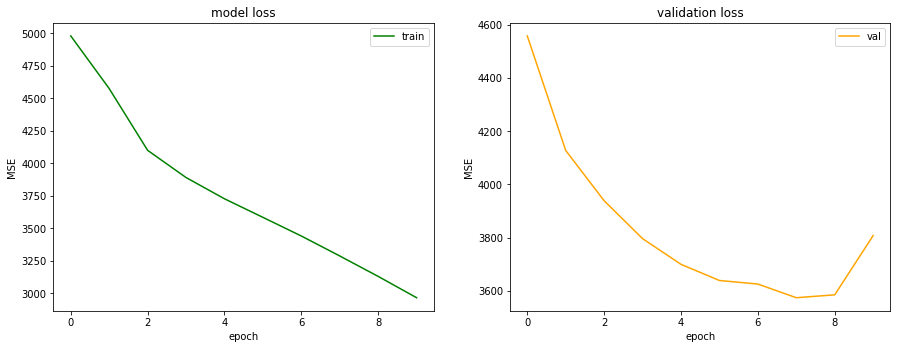

(1245252.625,
 {'loss': [4979.5283203125,
   4574.337890625,
   4099.1083984375,
   3889.664794921875,
   3726.08056640625,
   3583.25927734375,
   3439.63916015625,
   3286.081787109375,
   3128.7041015625,
   2964.791015625],
  'val_loss': [4557.92578125,
   4127.1904296875,
   3938.199462890625,
   3795.823974609375,
   3699.20068359375,
   3638.494140625,
   3625.069091796875,
   3573.7734375,
   3584.5615234375,
   3807.48046875]})

In [ ]:
#glove300
GRU_embed_models(glove_emb_index, "glove300", word_index, 300)

####Results

The word embedding model Cbow with 300 dimension performs the best. The GloVe is the second best. Even if the GloVe was trained on more data, the Cbow is more fitted on the underlying data. Moreover, it can be assumed that the implementation of bigram has a positive effect. The skip-gram model with 150 dimension performs by far the worst. It also shows big jumps in the train and validation history.

\begin{array}{lll}
Word \: Embedding \: Model & Dimension & MSE \: on \: Test Set\\
\hline
Cbow & 150 & 1,246,689.75 \\
Cbow & 300 & \bf{1,244,447.63} \\
Skip-gram & 150 & 1,263,030.00 \\
Skip-gram & 300 & 1,247,335.88 \\
GloVe & 300 & 1,245,252.63 \\
\end{array}

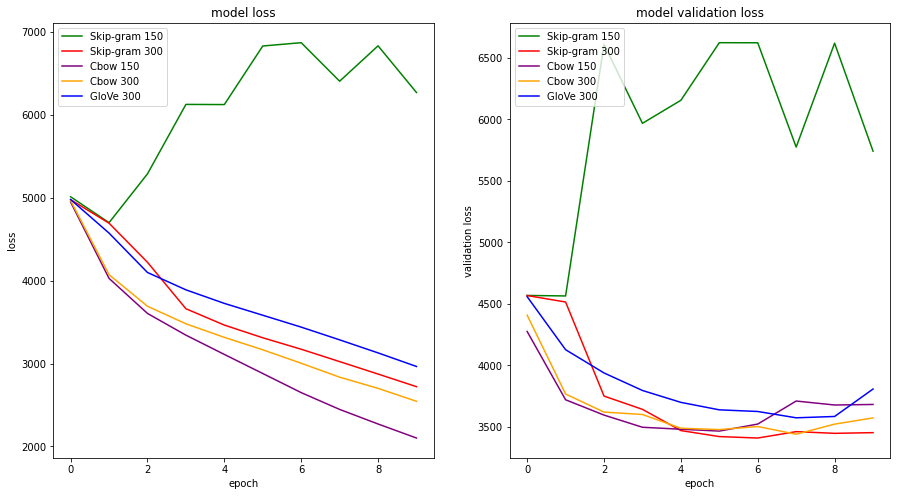

In [ ]:
plt.figure(figsize=(15, 8))

#show loss
plt.subplot(1, 2, 1)
plt.plot(GRU_models_hist['sg150']['loss'], color="green")
plt.plot(GRU_models_hist['sg300']['loss'], color="red")
plt.plot(GRU_models_hist['cbow300']['loss'], color="purple")
plt.plot(GRU_models_hist['cbow150']['loss'], color="orange")
plt.plot(GRU_models_hist['glove300']['loss'], color="blue")
plt.legend(labels = ("Skip-gram 150", "Skip-gram 300", "Cbow 150", "Cbow 300", "GloVe 300"), loc = "upper left")
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")

#show validation loss
plt.subplot(1, 2, 2)
plt.plot(GRU_models_hist['sg150']['val_loss'], color="green")
plt.plot(GRU_models_hist['sg300']['val_loss'], color="red")
plt.plot(GRU_models_hist['cbow300']['val_loss'], color="purple")
plt.plot(GRU_models_hist['cbow150']['val_loss'], color="orange")
plt.plot(GRU_models_hist['glove300']['val_loss'], color="blue")
plt.legend(labels = ("Skip-gram 150", "Skip-gram 300", "Cbow 150", "Cbow 300", "GloVe 300"), loc = "upper left")
plt.title("model validation loss")
plt.ylabel("validation loss")
plt.xlabel("epoch")
#plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()

###Prediction Models

We will predict the number of claps with help of a Multi-Layer-Perceptron (MLP), a Gated Recurrent Unit (GRU) and a Bidirectional GRU. <br>For all models the activation function "rectified linear" (relu) is applied since it ensures that the output is positive. All negative outputs are set to zero. This behaviour is favorable because the number of claps can never be negative -- as least not on the blog posts of our data set. Moreover, the relu activation functions overcome the problem of a vanishing gradient which is especially important for bidirectional architectures or neural networks with many layers. Additionally, the computation is very efficiently [8]<br>
Also one classifier is applied to all models. It is called "Adam". It can be used instead of the classical stochastic gradient descent. In contrast to the classical stochastic gradient descent, Adam updates the weights during training in an individual and adaptive manne. [9] As the original paper states, it combines the benefits are the classifer Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp) -- handling problem with sparse gradients but also dealing with e.g. noice. Further benefits that are presented in the orginal paper are an efficient computation and the good performance on big data. [10] <br>
As presented in the results of the word embedding evaluation, the embedding matrix of the Cbow model with 300 dimensions is used. To increase performance in the next models, we use the already pretrained embedding weights that were saved during evaluation or rather training process of the word embeddings.

####Multi-Layer-Perceptron (MLP)

Single neurons cannot solve complex task because they are restricted to a linear function. In order to overcome this problem, non-linearity is needed. A MLP is one way to do that. It is a finite directed acyclic graph with neurons that are activated with some activaton function which is in our case relu. The architecture consists of an input layer which is not a target to any connection, an output layer which are, in contrast to the input layer, no source of any connection and a hidden layer which is a layer that is not the input nor output layer. MLPs are also called vanila neural network and belong to the group of feedforward artificial neural networks. [11]

In [ ]:
cbow300_emb_index = load_embedding(os.getcwd() + "/" + "cbow_300_bigram_embeddings.txt")
cbow300_emb_mat = generate_emb_mat(word_index_train, cbow300_emb_index, 300) #dim = 300

In [ ]:
embedding_layer = Embedding(input_dim = no_of_words,
                            output_dim = 300, #embed_dim,
                            input_length = 402,
                            embeddings_initializer=Constant(cbow300_emb_mat),
                            trainable= True)

#MLP set up
model = Sequential()
model.add(embedding_layer)
model.add(Dense(100))
model.add(Dropout(0.4))
model.add(Dense(1, activation = "relu"))
model.compile(loss = "mse", optimizer = "adam")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 402, 300)          61722600  
_________________________________________________________________
dense (Dense)                (None, 402, 100)          30100     
_________________________________________________________________
dropout (Dropout)            (None, 402, 100)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 402, 1)            101       
Total params: 61,752,801
Trainable params: 61,752,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.load_weights("GRU_cbow300_10ep_64ba.h5")

In [ ]:
model.fit(X_train, y_train, validation_split = val_split, epochs= epochs, batch_size = batch_size, verbose = 1)

Epoch 1/10
312/312 [==============================] - 285s 913ms/step - loss: 5061.3452 - val_loss: 4614.2632
Epoch 2/10
312/312 [==============================] - 285s 915ms/step - loss: 4716.9189 - val_loss: 4555.1558
Epoch 3/10
312/312 [==============================] - 286s 916ms/step - loss: 4674.0293 - val_loss: 4538.6680
Epoch 4/10
312/312 [==============================] - 286s 917ms/step - loss: 4643.7314 - val_loss: 4525.1450
Epoch 5/10
312/312 [==============================] - 287s 920ms/step - loss: 4624.7217 - val_loss: 4506.7173
Epoch 6/10
312/312 [==============================] - 287s 919ms/step - loss: 4606.0815 - val_loss: 4514.4492
Epoch 7/10
312/312 [==============================] - 287s 921ms/step - loss: 4595.4150 - val_loss: 4494.6211
Epoch 8/10
312/312 [==============================] - 285s 913ms/step - loss: 4582.2612 - val_loss: 4494.1226
Epoch 9/10
312/312 [==============================] - 283s 906ms/step - loss: 4573.1211 - val_loss: 4492.7319
Epoch 10/1

In [ ]:
MLP_MSE = model.evaluate(X_test, y_test, verbose = 0)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
models.update({MLP_MSE})

####GRU with trained weights

GRUs and LSTMs have very similar recurrent neural network architectures that aim to solve the vanishing gradient problem which is typically introduced by standard recurrent neural networks (RNN) [12]. However, GRUs are computationally less costly to implement. Moreover, LSTM does not perform better in general. [13] Therefore, we decided to implement a GRU and run e.g. more epochs. <br> In contrast to an standard RNN, the architecture of GRU contain a update and reset gate. These two types of gates decides on which information is passed through to the next layer. However, they can still keep long term information which does not vanish over time like it would in a standard RNN. The update gate controlls if information is copied for instance or if only a little bit of information is passed through. Additionally, the reset gate supports in that way that it decides how much of the previous information can be forgotten. [12] <br>GRUs work in an online mode which means that they do not know the whole text in advance but rather learn word by word. In contrast bidirectional GRU work in an offline mode. This means that they know the text sequence as a whole. In some context it is crucial to know the whole context beforehand like in text summarization. [14] <br>



In [ ]:
#load generated embedding matrix
cbow300_emb_index = load_embedding(os.getcwd() + "/" + "cbow_300_bigram_embeddings.txt")
cbow300_emb_mat = generate_emb_mat(word_index_train, cbow300_emb_index, 300) #dim = 300

In [ ]:
#Size of RNN hidden state. Rule of thumb for RNN hidden state size: 'the optimal size of the hidden layer is usually between the size of the input and size of the output layers'. -Jeff Heaton, author of Introduction to Neural Networks in Java
#embedding layer
embedding_layer = Embedding(input_dim = no_of_words,
                            output_dim = 300, #embed_dim,
                            input_length = 402, #max_len_text,
                            embeddings_initializer=Constant(cbow300_emb_mat),
                            trainable=True)
                            #embeddings_regularizer=l2_reg)


#GRU set up
model = Sequential()
model.add(embedding_layer)
model.add(GRU(100)) #, weights = pre_weights)
model.add(Dropout(0.2))
model.add(Dense(1, activation = "relu"))
model.compile(loss = "mse", optimizer = "adam")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 402, 300)          69626700  
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               120600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 69,747,401
Trainable params: 69,747,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.load_weights("GRU_cbow300_10ep_64ba.h5") #load pretrained weights

In [ ]:
model_hist_GRU_w = model.fit(X_train, y_train, validation_split= val_split, epochs= epochs, batch_size = batch_size) #validation_data=(X_test, y_test)

Epoch 1/20
312/312 [==============================] - 759s 2s/step - loss: 2062.7976 - val_loss: 3704.5308
Epoch 2/20
312/312 [==============================] - 759s 2s/step - loss: 1653.6630 - val_loss: 3828.9692
Epoch 3/20
312/312 [==============================] - 750s 2s/step - loss: 1362.3687 - val_loss: 3915.8696
Epoch 4/20
312/312 [==============================] - 765s 2s/step - loss: 1086.8198 - val_loss: 3997.7192
Epoch 5/20
312/312 [==============================] - 767s 2s/step - loss: 895.4716 - val_loss: 4064.7925
Epoch 6/20
312/312 [==============================] - 767s 2s/step - loss: 767.1475 - val_loss: 4242.9126
Epoch 7/20
312/312 [==============================] - 760s 2s/step - loss: 614.1409 - val_loss: 4158.6689
Epoch 8/20
312/312 [==============================] - 766s 2s/step - loss: 533.3627 - val_loss: 4212.9863
Epoch 9/20
312/312 [==============================] - 750s 2s/step - loss: 452.2273 - val_loss: 4286.1270
Epoch 10/20
312/312 [=====================

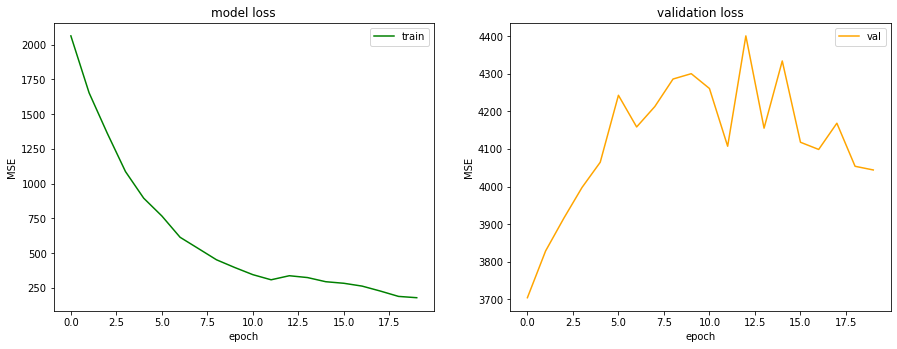

In [ ]:
plot_hist(model_hist_GRU_w)

In [ ]:
y_pred = model.predict(X_test)
mse_GRU = mean_squared_error(y_test, y_pred)

In [ ]:
mse_GRU

1238598.8923287229

####Bidirectional GRU

In [ ]:
#size of RNN hidden state. Rule of thumb for RNN hidden state size: 'the optimal size of the hidden layer is usually between the size of the input and size of the output layers'. -Jeff Heaton, author of Introduction to Neural Networks in Java

#embedding layer
embedding_layer = Embedding(input_dim = no_of_words,
                            output_dim = 300, #embed_dim,
                            input_length = 402, #max_len_text,
                            embeddings_initializer=Constant(cbow300_emb_mat),
                            trainable=True)
                            #embeddings_regularizer=l2_reg)


#GRU set up
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(100), merge_mode = "concat")) #, weights = pre_weights)
model.add(Dropout(0.4))
model.add(Dense(1, activation = "relu"))
model.compile(loss = "mse", optimizer = "adam")
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 402, 300)          69626700  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               241200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 69,868,101
Trainable params: 69,868,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_hist_BiGRU = model.fit(X_train, y_train, validation_split= val_split, epochs= epochs, batch_size = batch_size) #validation_data=(X_test, y_test)

Epoch 1/10
312/312 [==============================] - 1224s 4s/step - loss: 4922.8496 - val_loss: 4353.7422
Epoch 2/10
312/312 [==============================] - 1274s 4s/step - loss: 4034.5369 - val_loss: 3667.1392
Epoch 3/10
312/312 [==============================] - 1225s 4s/step - loss: 3312.4834 - val_loss: 3395.3215
Epoch 4/10
312/312 [==============================] - 1266s 4s/step - loss: 2406.7710 - val_loss: 3559.4353
Epoch 5/10
312/312 [==============================] - 1306s 4s/step - loss: 1594.3810 - val_loss: 3720.5793
Epoch 6/10
312/312 [==============================] - 1304s 4s/step - loss: 1040.1787 - val_loss: 3861.9666
Epoch 7/10
312/312 [==============================] - 1299s 4s/step - loss: 721.3184 - val_loss: 3832.3081
Epoch 8/10
312/312 [==============================] - 1322s 4s/step - loss: 524.5369 - val_loss: 3907.1851
Epoch 9/10
312/312 [==============================] - 1354s 4s/step - loss: 393.2196 - val_loss: 3867.0562
Epoch 10/10
312/312 [==========

In [ ]:
model.save("BiGRU_10.h5")

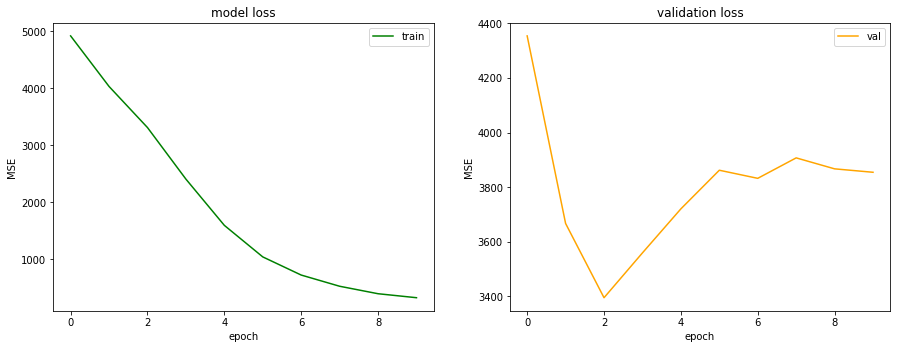

In [ ]:
plot_hist(model_hist_BiGRU)

In [ ]:
from keras import models    
model = models.load_model('BiGRU_10.h5')

In [ ]:
BiGru_mse = model.evaluate(X_test, y_test, verbose = 0)
BiGru_mse

1248442.625

In [ ]:
?model.evaluate

####Results

The models are compared with their scalar test loss which is in our case equal to the mean-squared-error since we specified loss as "mse" in all models set-ups. The function model.evaluate(X_test, y_test) returns two scores. The loss and the accuracy (not specified in our analysis).


\begin{array}{ll}
Model & MSE \\
\hline
Elastic Net & 1,243,992.29 \\
MLP \:10 & 1,257,236.75 \\
Gru \:20 & 1,238,598.89 \\
BiGru \:10 & 1,248,442.63 \\
\end{array}

Even though the dropout rates of the GRU and BiGRU are with 0.4 quite high and should prevent the model from overfitting, both models seem to suffer from overfitting. Nevertheless, the forward GRU that trained 20 epochs performed the best in spite of overfitting and therefore will be used for the final prediction.

In [ ]:
models

##Test Set Prediction

In [ ]:
from keras import models    
model = models.load_model('GRU_test.h5')

In [ ]:
#combine, header und text, clean text
#clean author, clean zum numbers, check for empty authors

data_file = "Test.csv"
test = pd.read_csv(data_file, encoding='utf-8')
del(test["Unnamed: 0"])
#test = test.drop("index", axis=1)
#test = test.reset_index()

In [ ]:
#extract number of responses, remove all characters which is not numeric, impute missing value with value 0

print(test.Responses.isnull().sum())
test.Responses[test.Responses.isnull()] = 0
print(test.Responses.isnull().sum())

def clean_respond(row, df_length):
  
  row["Responses"] = str(row["Responses"])
  row["Responses"] = re.sub("[^0-9]", " ", row["Responses"])

  return row

test = test.apply(lambda row: clean_respond(row, len(test)), axis=1)

82
0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
#extract date zum PublicationDetails, remove all characters which is not numeric

def clean_publ(row, df_length):
  
  #row["Responses"] = str(row["Responses"])
  row["PublicationDetails"] = row["PublicationDetails"].replace("Dec", "12")
  row["PublicationDetails"] = row["PublicationDetails"].replace("Nov", "11")
  row["PublicationDetails"] = row["PublicationDetails"].replace("Oct", "10")
  row["PublicationDetails"] = row["PublicationDetails"].replace("Sep", "09")
  row["PublicationDetails"] = row["PublicationDetails"].replace("Aug", "08")
  row["PublicationDetails"] = row["PublicationDetails"].replace("Jul", "07")
  row["PublicationDetails"] = row["PublicationDetails"].replace("Jun", "06")
  row["PublicationDetails"] = row["PublicationDetails"].replace("May", "05")
  row["PublicationDetails"] = row["PublicationDetails"].replace("Apr", "04")
  row["PublicationDetails"] = row["PublicationDetails"].replace("Mar", "03")
  row["PublicationDetails"] = row["PublicationDetails"].replace("Feb", "02")
  row["PublicationDetails"] = row["PublicationDetails"].replace("Jan", "01")
  
  return row

test = test.apply(lambda row: clean_publ(row, len(test)), axis=1) 

test["date"] = [re.sub("[^0-9]", "", x) for x in test["PublicationDetails"]]
test["year"] = [int(str(x)[-4:]) for x in test["date"]]
test["author_info"] = [re.sub("[0-9]", "", x) for x in test["PublicationDetails"]]

In [ ]:
#author cleaning: remove digits/date from var

def clean_author(row, df_length):
  
  row["Author"] = row["Author"].replace("Dec", "12")
  row["Author"] = row["Author"].replace("Nov", "11")
  row["Author"] = row["Author"].replace("Oct", "10")
  row["Author"] = row["Author"].replace("Sep", "09")
  row["Author"] = row["Author"].replace("Aug", "08")
  row["Author"] = row["Author"].replace("Jul", "07")
  row["Author"] = row["Author"].replace("Jun", "06")
  row["Author"] = row["Author"].replace("May", "05")
  row["Author"] = row["Author"].replace("Apr", "04")
  row["Author"] = row["Author"].replace("Mar", "03")
  row["Author"] = row["Author"].replace("Feb", "02")
  row["Author"] = row["Author"].replace("Jan", "01")
  
  return row

test = test.apply(lambda row: clean_author(row, len(test)), axis=1) 
test["Author"] = [re.sub("[0-9]", "", x) for x in test["Author"]]
test["Author"] = test["Author"].replace(" , ", "Unknown")
test["Author"] = test["Author"].replace("-", "Unknown")

In [ ]:
def clean_split(row, df_length):

  #row["author_info"] = str(row["author_info"])
  #row["author_info"] = row["author_info"].split("in")
  row["author_info"] = row["author_info"].partition('in')[0]
  row["author_info"] = re.sub("[^a-zA-Z]", " ", row["author_info"])
  row["author_info"] = ' '.join( [w for w in row["author_info"].split() if len(w)>1] )
  
  return row

test = test.apply(lambda row: clean_split(row, len(test)), axis=1) 

In [ ]:
test["Author"] = np.where((test["Author"] == "Unknown") & (test["author_info"] != ""), test["author_info"], np.where((test["Author"] == "Unknown") & (test["author_info"] == ""), "Unknown", test["Author"]))

In [ ]:
test.tail()

,index,Author,PublicationDetails,Responses,Header,Text,Length,date,year,author_info
509,598,Tim Romero,"Tim Romero in Startup Lessons Learned06 9, 2016",181,"Why I turned down $500K, Pissed off my investo...",I just did what no startup founder is ever sup...,9025,0692016,2016,Tim Romero
510,599,Product Hunt,"Product Hunt06 10, 2016",24,These Tools Will Help You Launch Your Startup,If you’re embarking on the startup journey and...,5571,06102016,2016,Product Hunt
511,600,Joe Procopio,Joe Procopio03 19,24,Why Startups Fall Apart at 50 Employees,Fuck you startups with your extravagant partie...,475,0319,319,Joe Procopio
512,601,Unknown,"Winerist in Be Yourself03 18, 2016",116,Beware of Startup Prostitution,Note: This is not a post to glorify prostituti...,13483,03182016,2016,
513,602,Aytek,"Aytekin Tank in The Startup01 11, 2018",34,How to build a startup — without quitting your...,Question: What do Craigslist and Albert Einste...,8736,01112018,2018,Aytek


In [ ]:
test.loc[test.Author == "Product Hunt", ["Author"]]

,Author
505,Product Hunt
510,Product Hunt


In [ ]:
#Reset missing values in Header, otherwise, the next processing step does not work properly, 0 is implement because it is easy to apply, store and remove in the text cleaning
test["Header"] = np.where(test.Header.isnull(), 0, test["Header"])

#Merge headlines and texts 
test["text_full"] = test["Header"].astype(str) + " " + test["Text"]

#Clean text like the training set
def clean_all(row, df_length):
  
  row["text_full"] = cleaning_function(row["text_full"])

  print(f"\rcompleted: {row.name + 1} of {df_length}", end="")
  return row

t1 = time.perf_counter()
#für später: tr_new anstatt df (2x)
#train_cleaned = tr_new.reset_index()
#train_cleaned = train_cleaned.drop("index", axis=1)
test_cleaned = test.apply(lambda row: clean_all(row, len(test)), axis=1)
t2 = time.perf_counter()

print("It took {:.2f} minutes to compile".format((t2-t1)/60))

completed: 514 of 514It took 0.38 minutes to compile


In [ ]:
X_test = test_cleaned.loc[:,["text_full"]]

tokenizer_obj = Tokenizer() #vectorizes the text corpus
tokenizer_obj.fit_on_texts(X_test["text_full"])
seq = tokenizer_obj.texts_to_sequences(X_test["text_full"])

from nltk.tokenize.treebank import TreebankWordDetokenizer
test_cleaned["text_full_detoken"] = [TreebankWordDetokenizer().detokenize(token) for token in test_cleaned["text_full"]] 

#max. length of text (of the training data)
max_len_text = max([len(x.split()) for x in test_cleaned["text_full_detoken"]]) #"text_cl" because tokens are not countable this way
print("Max. text length: {}".format(max_len_text))

X_test = pad_sequences(seq, 402) 
print(X_test.shape)


Max. text length: 2026
(514, 402)


In [ ]:
claps_pred = model.predict(X_test)

In [ ]:
data_file = "Sample_submission.csv"
sample = pd.read_csv(data_file, encoding='utf-8')

In [ ]:
test["Claps"] = claps_pred

In [ ]:
path = os.getcwd()
path

'/content/gdrive/My Drive/ADAMS/Assignment'

In [ ]:
test[["index","Claps"]].to_csv(path + "/finalprediction2.csv",index=False)

##Recap and Potential Next Steps

1) Tune the number of claps<br> 
Right now we choose a cutoff at 3*IQR. This cutoff effected about the top 12% of the observations. The finalprediction.csv file shows that the model has difficulties to predict a number of claps that was more than 150. Instead of taking a cutoff related to the IQR, one could cutoff the top x%. <p>
2) Focus on the sentiment analysis<br>
Use different dictionaries, form clusters or similar. <p>
3) Scrapping more data for the test set<br>
If allowed, one could also scrap more data for the test set to be able to use variable with very high correlations such as the train variable recommends with a correlation towards the target variable of 0.96. <p> 
4) Focus on publishing websites<br>
Extracting the websites on which the post first were published might show a correlation towards the number of claps.<p>
5) Tune parameters<br>
Tuning the parameter, more regularization to the GRUs etc.

## References

[1] Google Code Archive, word2vec, project created on Jul 30, 2013, https://code.google.com/archive/p/word2vec/. <br>
[2] Kennedy, J. J. (1970), The eta coefficient in complex ANOVA designs, Educational and Psychological Measurement, 30(4), 885-889. <br>
[3] Zakaria Jaadi, Everything you need to know about interpreting correlations, Towards Data Science. Oct 15, 2019.<br>
[4] Dhruvil Karani, Introduction to Word Embedding and Word2Vec, Towards Data Science, Sep 1, 2018.<br>
[5] Manish Chablani, Word2Vec (skip-gram model): PART 1 - Intuition. Jun 14, 2017.<br>
[6] Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. <br>
[7] Amar Mandal, Ridge, Lasso and Elastic Net Regularization methods. Jun 07, 2020.<br>
[8] Jason Brownlee, A Gentle Introduction to the Rectified Linear Unit (ReLU), Deep Learning Performance. Jan 09, 2019 (last update: Aug 20, 2020), https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/.<br>
[9] Jason Brownlee, Gentle Introduction to the Adam Optimization Algorithm for Deep Learning,  Deep Learning Performance. Jul 03, 2017 (last update: Aug 20, 2020) https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/. <br> 
[10] Kingma, D. P., & Ba, J. (2014). Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.<br>
[11] Prof. Dr. Martin Riedmiller, Machine Learning: Multi Layer Perceptrons, Albert-Ludwigs-University Freiburg AG Maschinelles Lernen, http://ml.informatik.uni-freiburg.de/former/_media/documents/teaching/ss09/ml/mlps.pdf. (last accessed: Aug 31, 2020).<br>
[12] Simeon Kostadinov, Understanding GRU Networks, Towards Data Science. Dec 16, 2017. https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be.<br>
[13] Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555.<br>
[14] Madhu Ramiah, Bi-directional RNN & Basics of LSTM and GRU. Jul 9, 2019. https://medium.com/@madhuramiah/bi-directional-rnn-basics-of-lstm-and-gru-e114aa4779bb.

